# evtree的产生原因

Commonly used classiﬁcation and regression tree methods like the rpart and CIT algorithm are **recursive partitioning** methods that build the model in a **forward stepwise search**.Although this approach is known to be an eﬃcient heuristic, the results of recursive tree methods are only **locally optimal**, as splits are chosen to maximize homogeneity at the next step only.

rpart和ctree都是局部最优算法，注意该算法的二点：

1. 着眼于“当前”；
2. 在所有可能(分枝属性和分枝点)中选择最好的。

这种算法存在二方面问题：

1. 当前最优的不一定是全局最优的；
1. 选择的分枝有可能势均力敌，那么就不能继续分枝，虽然异质性还很大。

下边的例子典型地证明了这二方面问题：

In [1]:
options(warn=-1)    #忽略一切警告
options('width'=140)  #充分利用打印宽度
options(repr.plot.width=22, repr.plot.height=10)  #满幅

library(pacman)
p_load(rpart,partykit,evtree,skimr,treemisc)
s <- skim_tee

生成人工数据集

In [2]:
x1 <- rep(seq(0.25, 1.75, 0.5), each = 4)     #生成横坐标
x2 <- rep(seq(0.25, 1.75, 0.5), 4)            #生成纵坐标
y <- rep(1, 16)#初始化标签
y[(x1 < 1 & x2 < 1) | (x1 > 1 & x2 > 1)] <- 2 #修改标签，让左下4个点与右上4个点同标签
y <- factor(y, labels = c("Red", "Black"))          #将标签转化为因子类型，决策树的因变量一般都为因子类型
chess22 <- data.frame(y, x1, x2)              #放入数据框中
s(chess22)


── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             16    
Number of columns          3     
_______________________          
Column type frequency:           
  factor                   1     
  numeric                  2     
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts    
1 y                     0             1 FALSE          2 Red: 8, Bla: 8

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate mean    sd   p0   p25 p50  p75 p100 hist 
1 x1                    0             1    1 0.577 0.25 0.625   1 1.38 1.75 ▇▇▁▇▇
2 x2                    0  

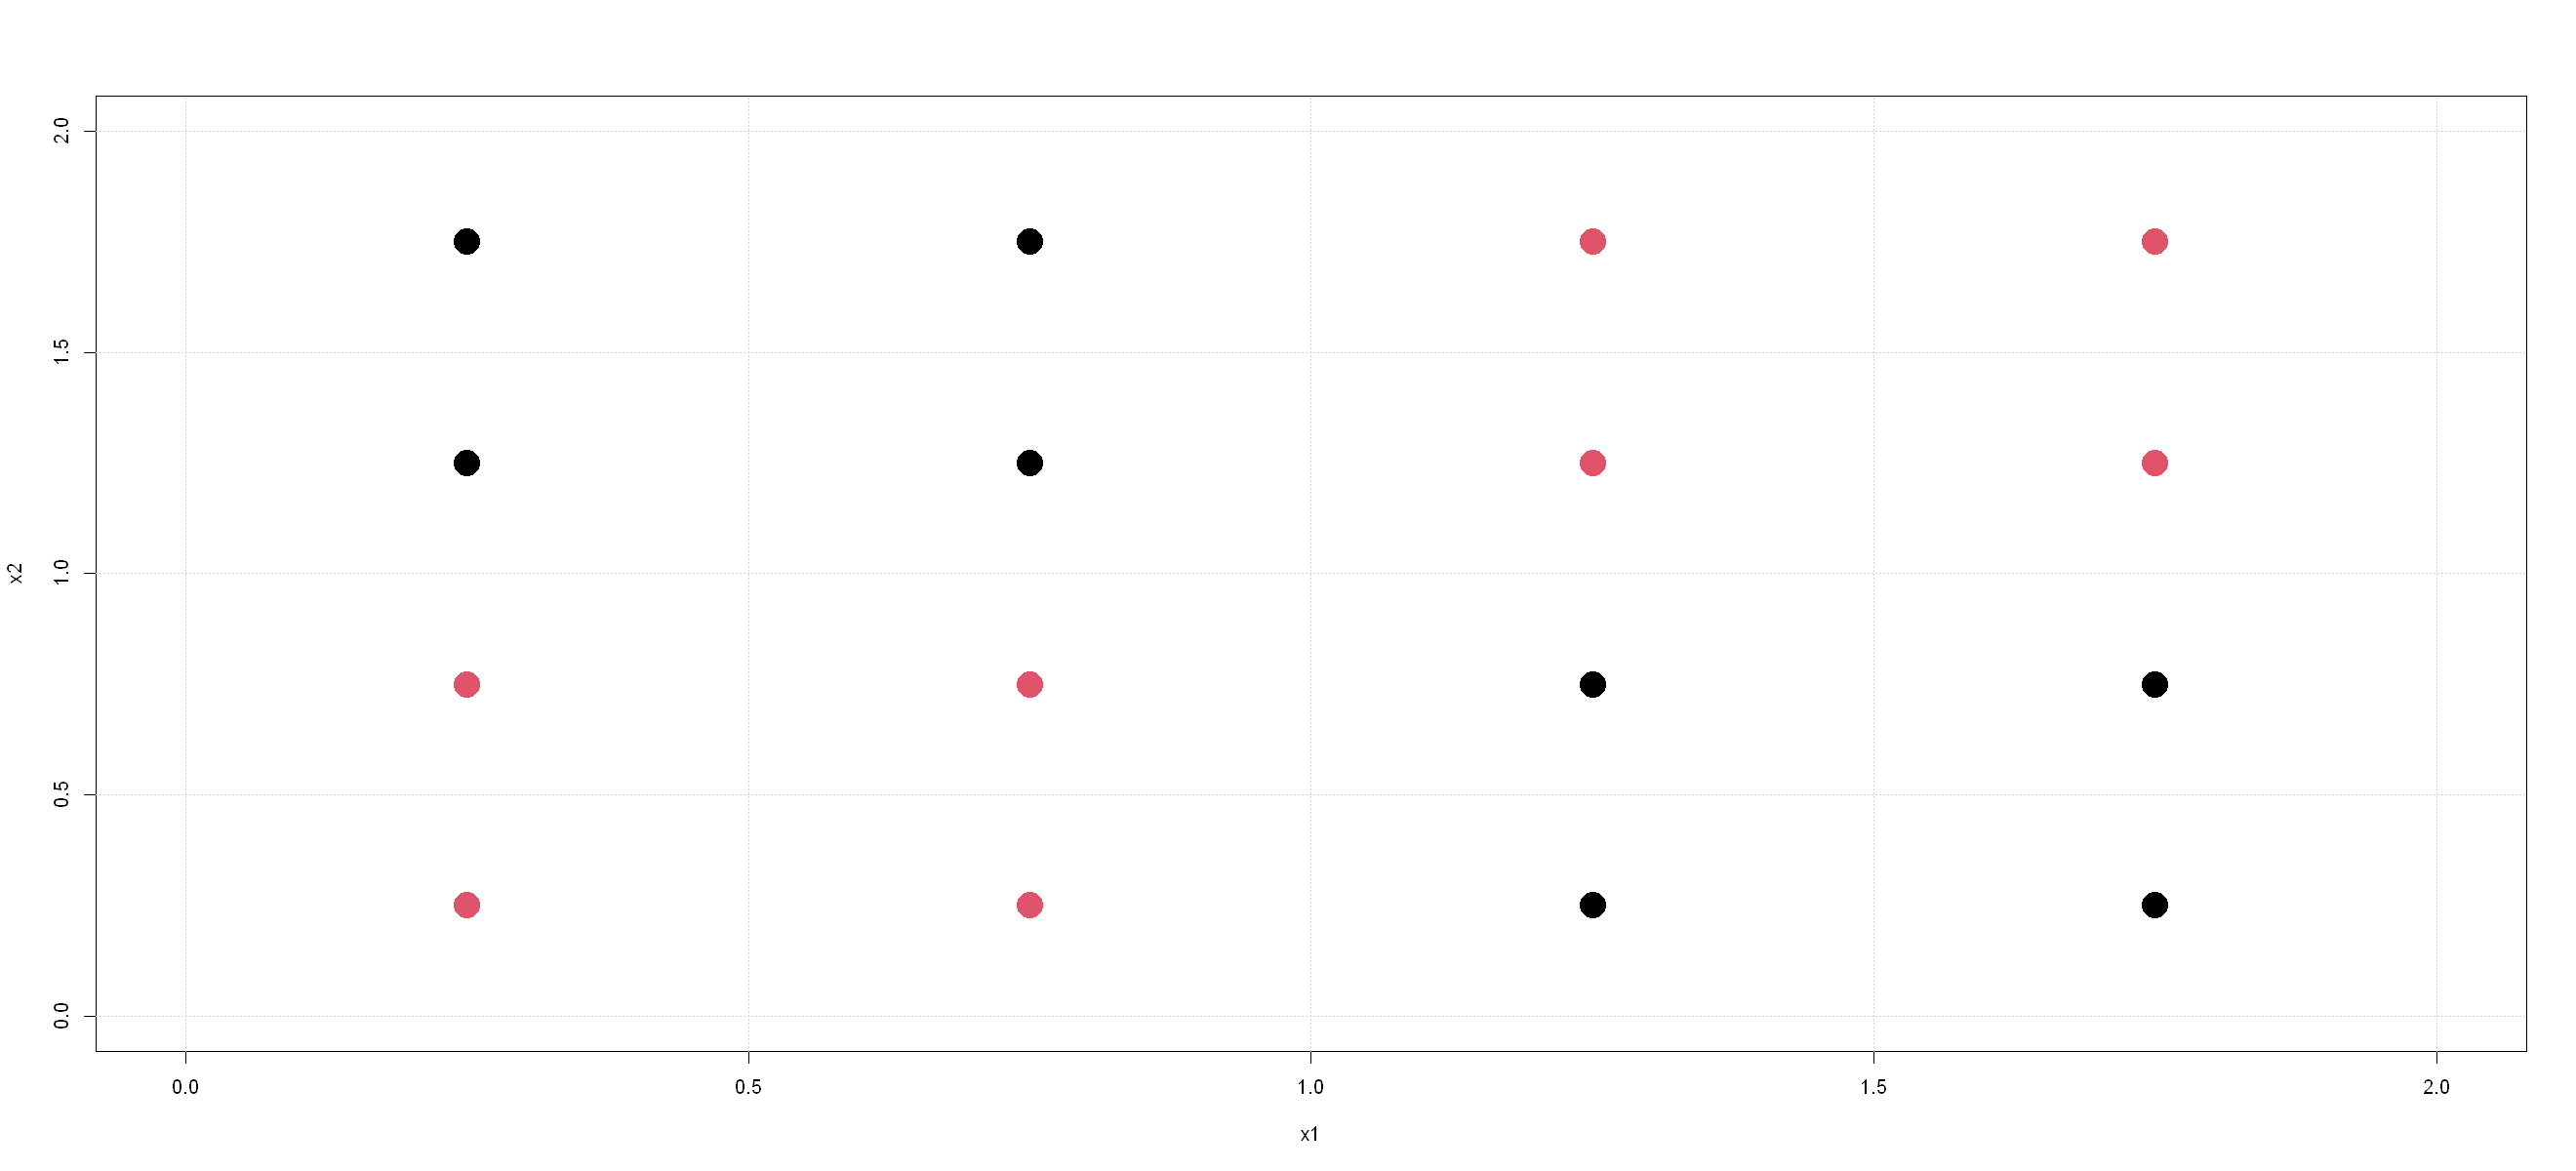

In [3]:
plot(x2 ~ x1, data = chess22, xlim = c(0, 2), ylim = c(0, 2), col = c(1, 2)[y], pch = 16, cex = 3)      #画出数据分布图像
grid()

**raprt算法**


Model formula:
y ~ x1 + x2

Fitted party:
[1] root: Red (n = 16, err = 50.0%) 

Number of inner nodes:    0
Number of terminal nodes: 1


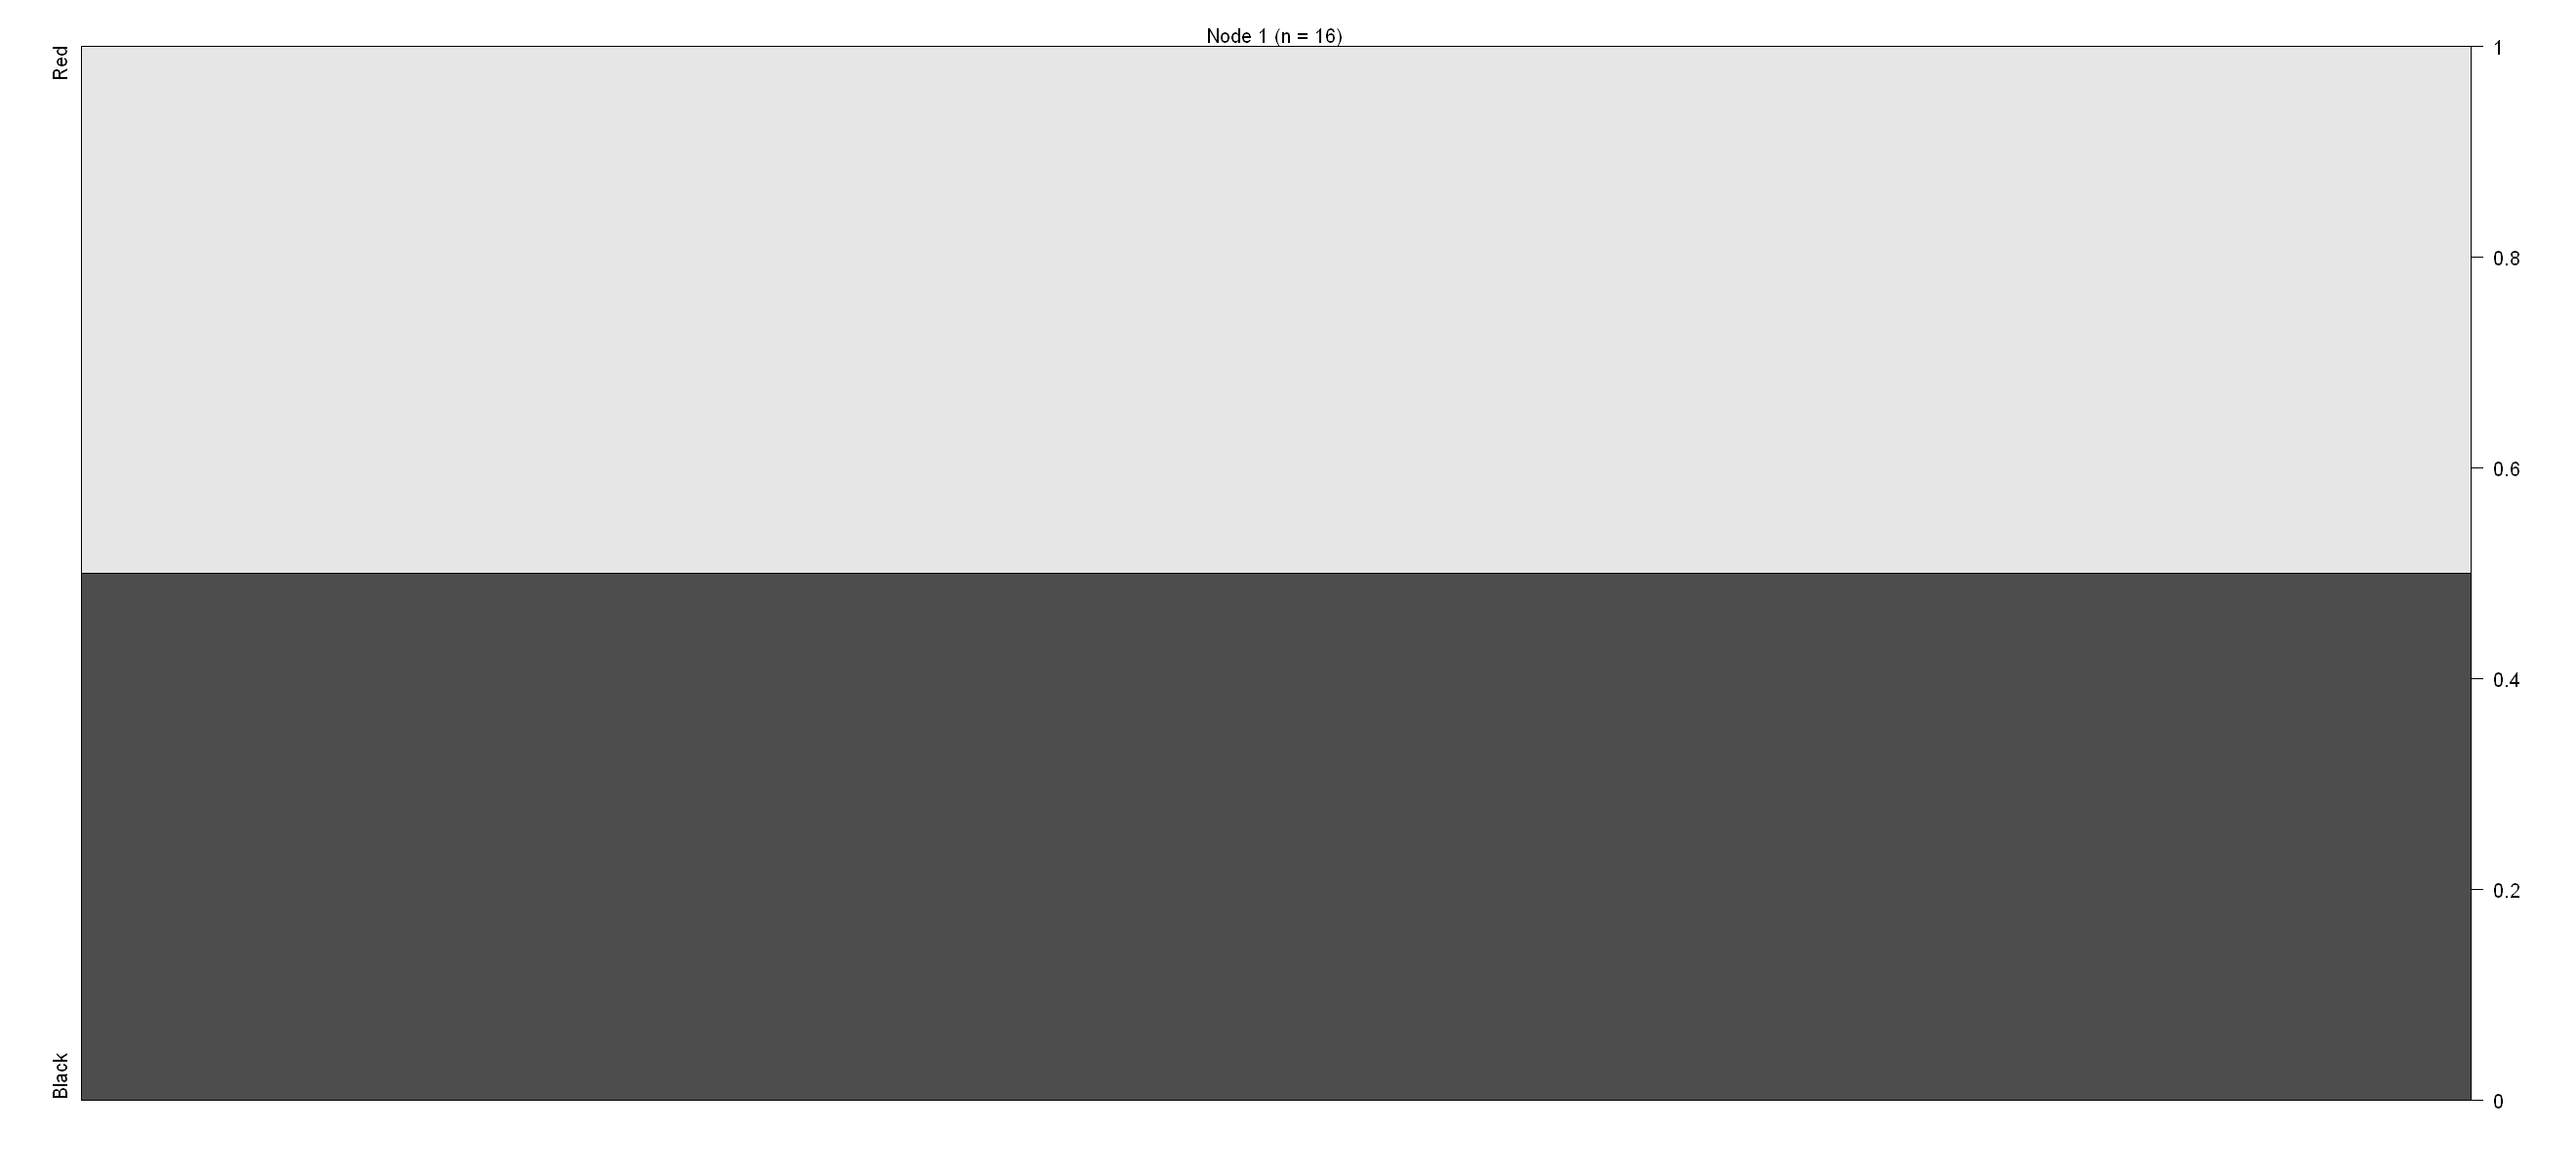

In [3]:
rp <- as.party(rpart(y ~ ., data = chess22))
print(rp)
plot(rp)


--raprt树只有根节点，未能有效地进行分类

**ctree算法**


Model formula:
y ~ x1 + x2

Fitted party:
[1] root: Red (n = 16, err = 50.0%) 

Number of inner nodes:    0
Number of terminal nodes: 1


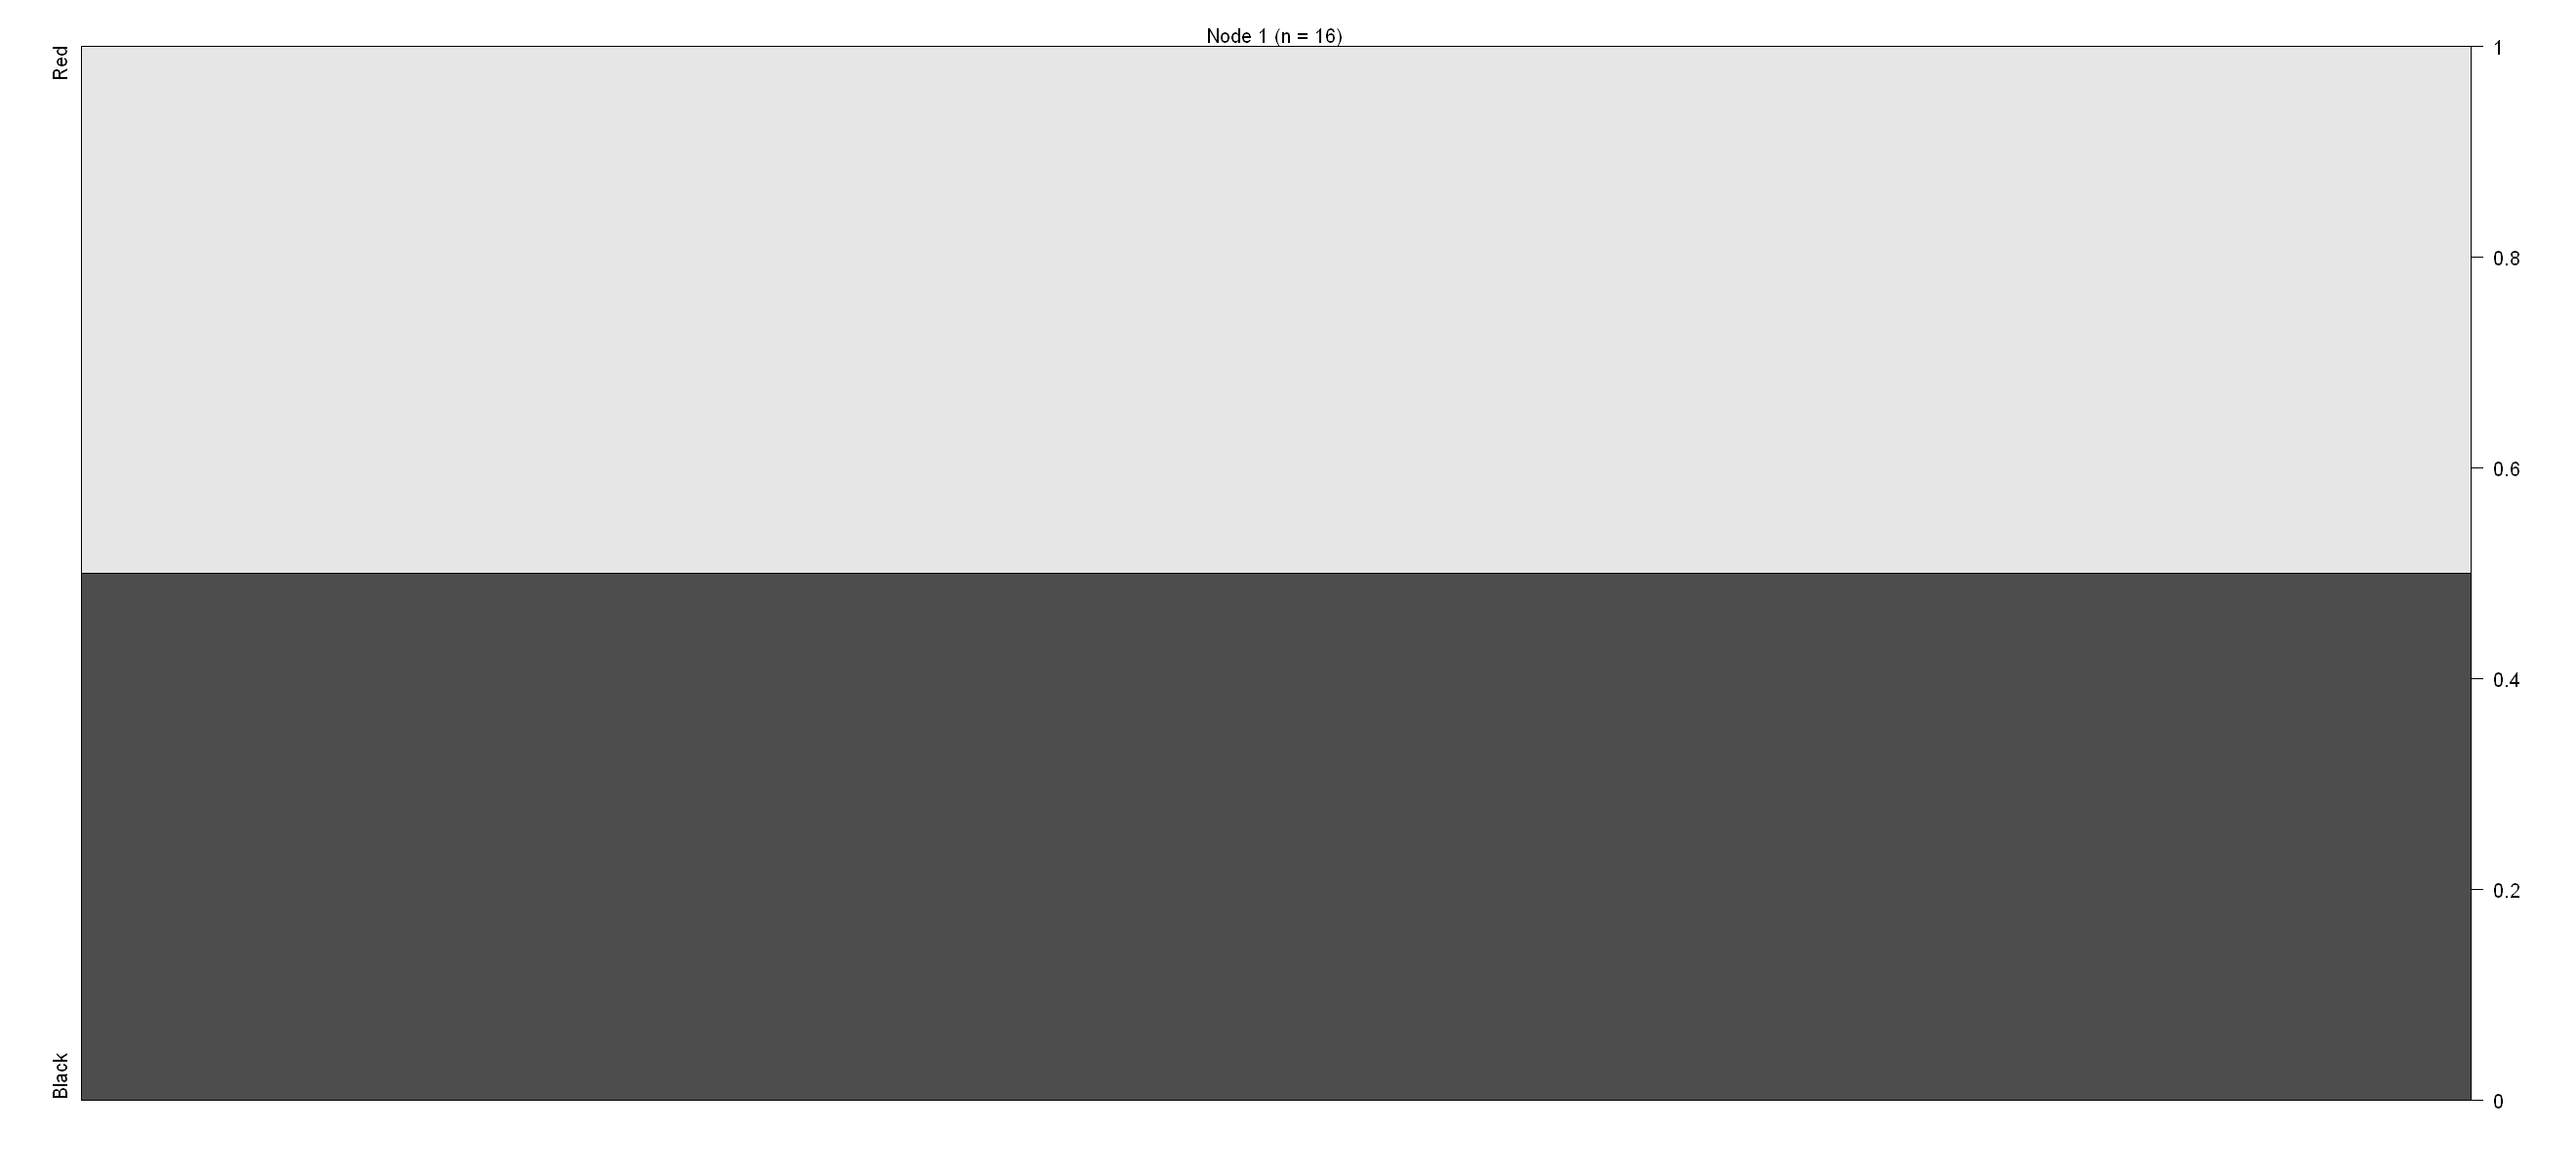

In [4]:
ct <- ctree(y ~ ., data = chess22)
print(ct)
plot(ct)

--ctree只有根节点，未能有效地进行分类

**evtree算法**


Model formula:
y ~ x1 + x2

Fitted party:
[1] root
|   [2] x1 < 1.25
|   |   [3] x2 < 1.25: Black (n = 4, err = 0.0%)
|   |   [4] x2 >= 1.25: Red (n = 4, err = 0.0%)
|   [5] x1 >= 1.25
|   |   [6] x2 < 1.25: Red (n = 4, err = 0.0%)
|   |   [7] x2 >= 1.25: Black (n = 4, err = 0.0%)

Number of inner nodes:    3
Number of terminal nodes: 4


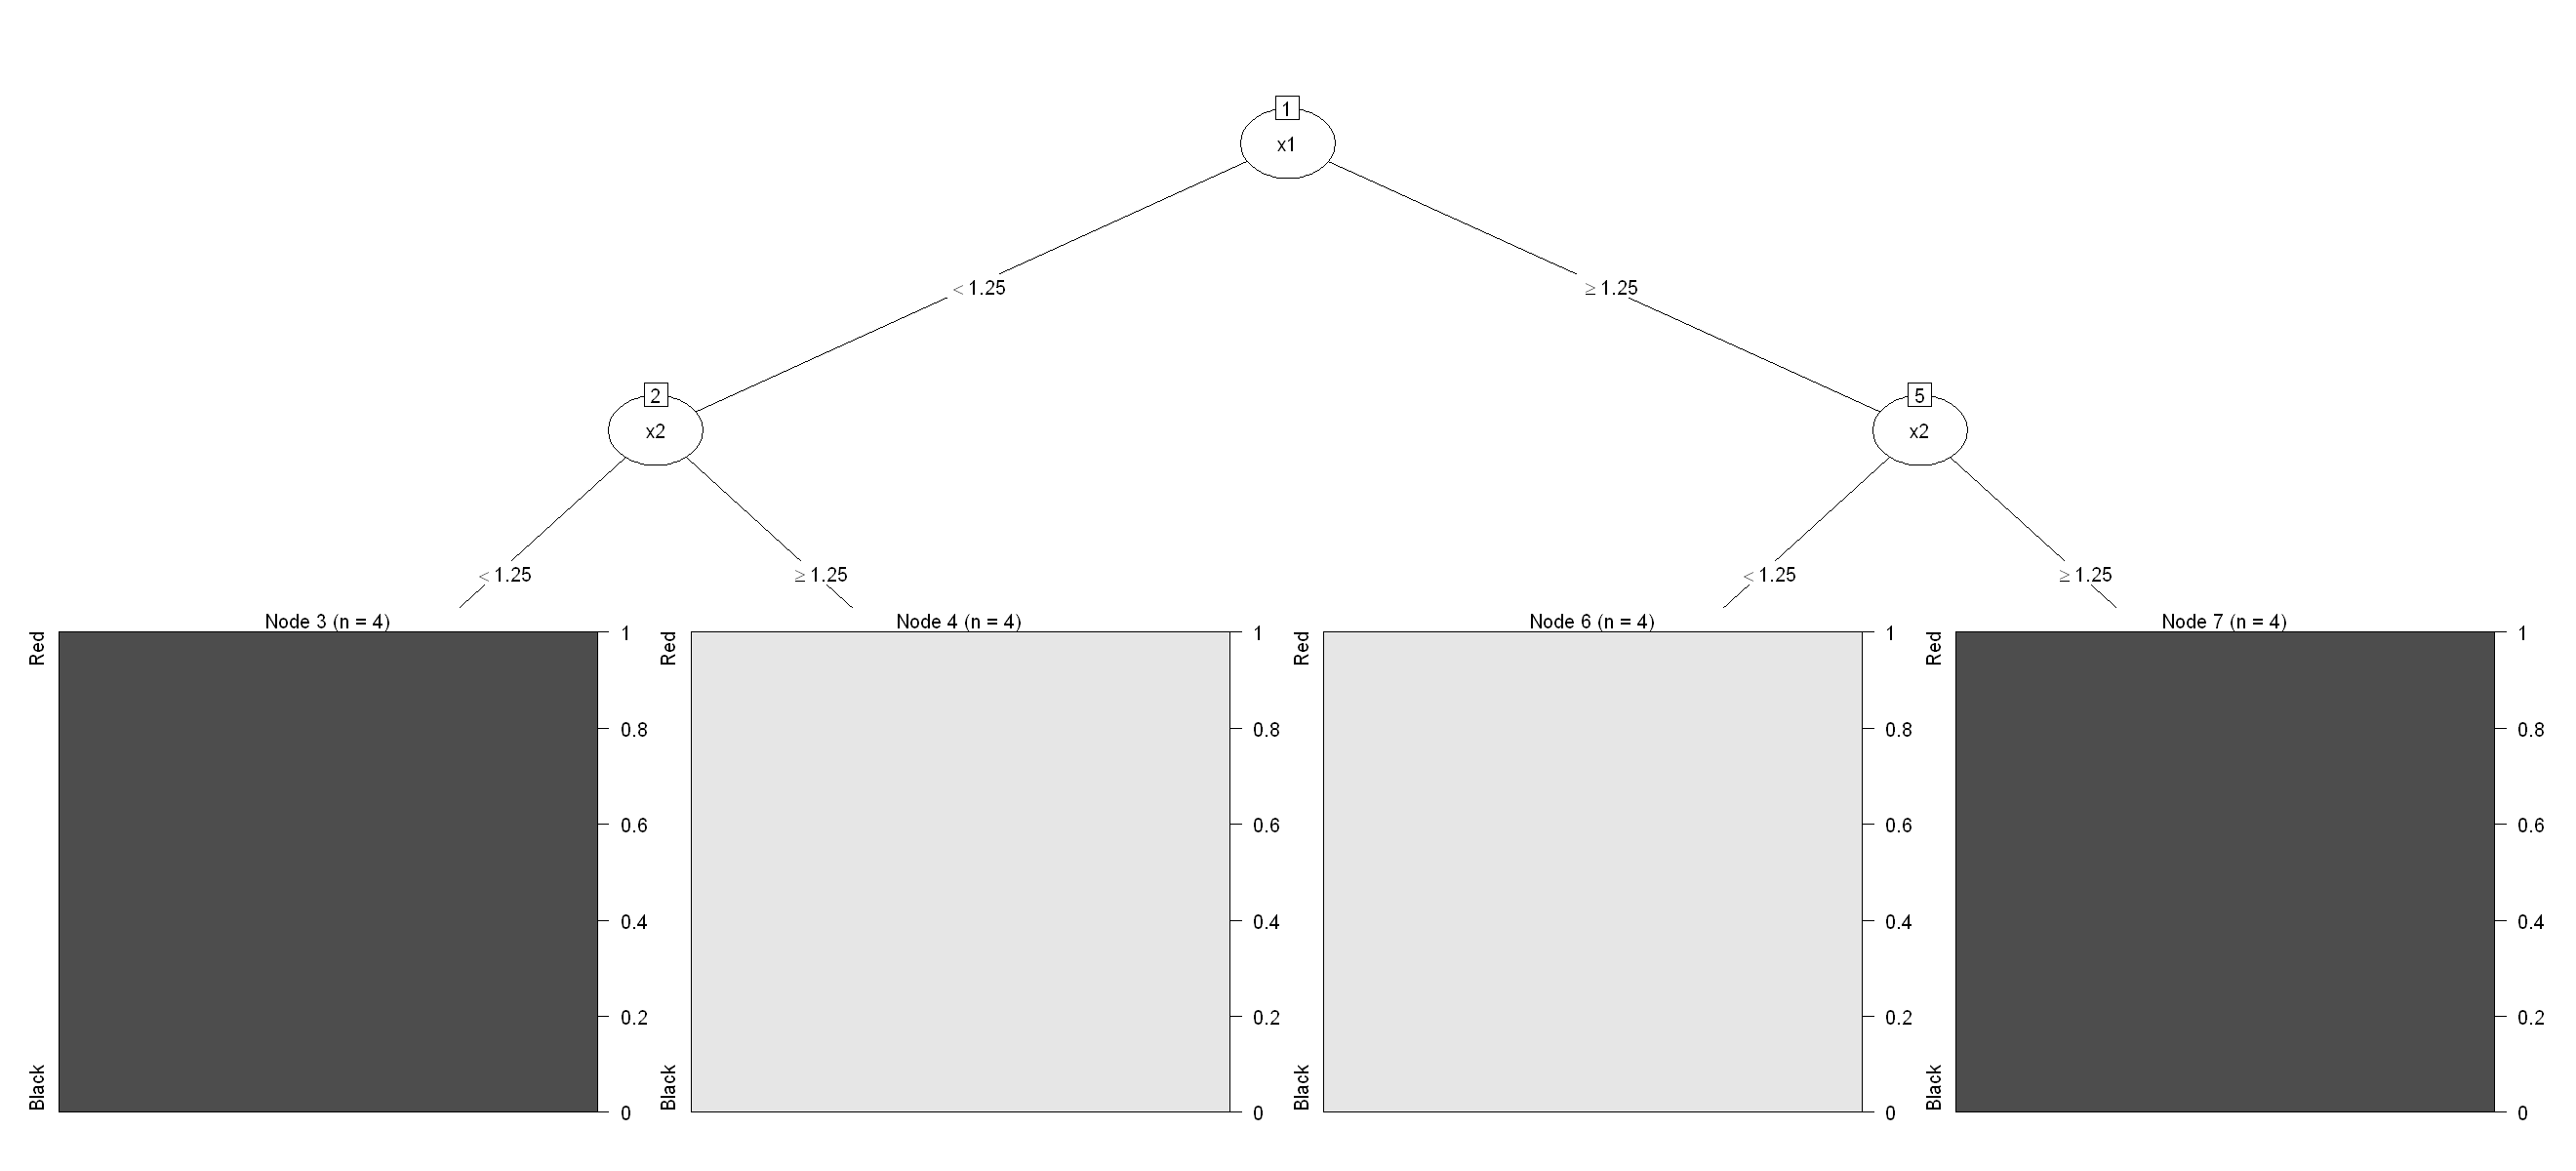

In [5]:
set.seed(1090)
ev <-evtree(y ~ ., data = chess22, minbucket = 1,minsplit = 2)
print(ev)
plot(ev)           

--evtree构建了性能优良的决策树，完美地将二类样例分开，如下：

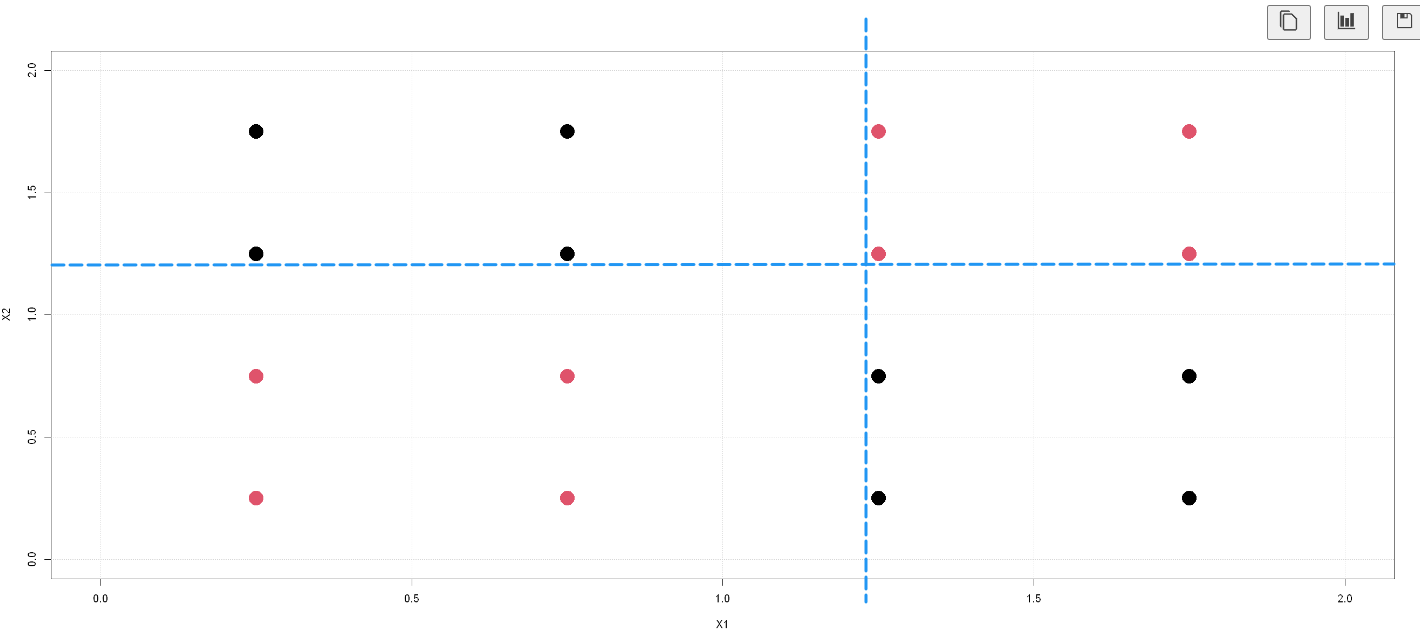

rpart和ctree算法均是由于x1和x2的分枝的评分(混乱度的降幅)相同，不能选出“首发”分枝，摔倒在起跑线上！

- Using the default parameters, the algorithm terminates when the quality of the **best 5% of trees stabilizes for 100 iterations, but not before 1000 iterations**. If the run does not converge the algorithm terminates after a user-speciﬁed number of iterations. 

- In cases where the algorithm does not converge, a warning message is written to the command line. 

- The tree with the highest quality according to the evaluation function is returned.

- Missing values are currently not supported by evtree.

问题再复杂一点：

红黑点的界限不分明，二者之间有交叉

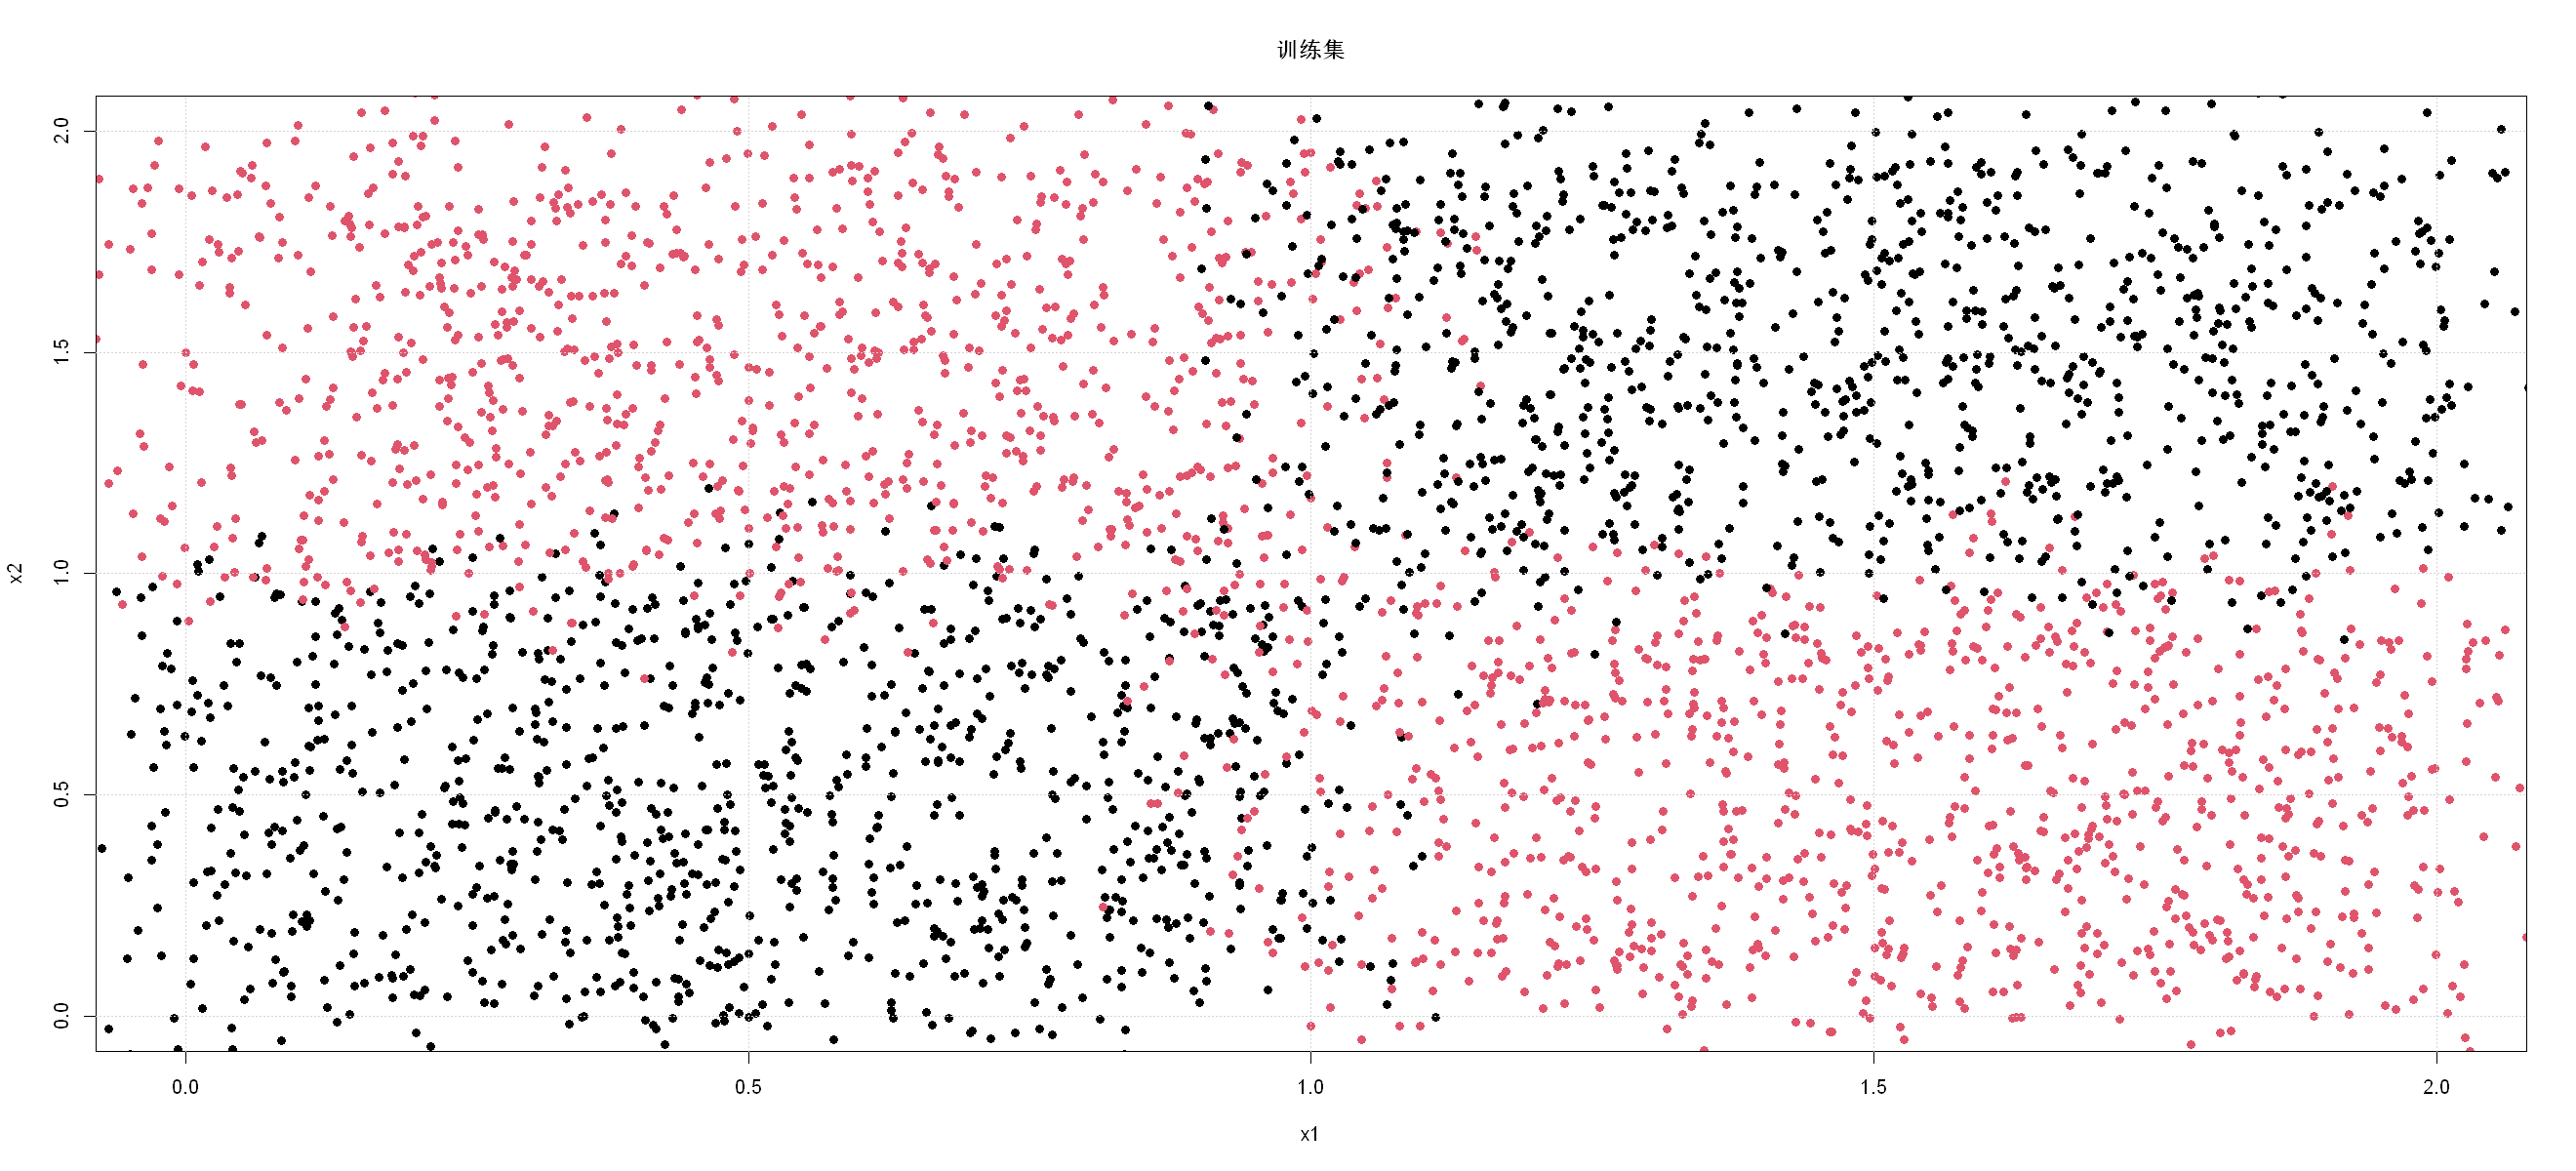

In [5]:
d_tr <- data.frame()    #存储训练集
d_te <- data.frame()    #存储测试集

#构建训练集和测试集
for (i in 0:1) {
  for (j in 0:1) {
    set.seed(i * 100 + j)
    x1 <- runif(1000, 0, 1) + rnorm(100) * 0.1 + i
    x2 <- runif(1000, 0, 1) + rnorm(100) * 0.1 + j
    y <- 1 + (i + j) %% 2
    d_tr <- rbind(d_tr, data.frame(x1, x2, y))

    set.seed(i * 1000 + j)
    x1 <- runif(1000, 0, 1) + rnorm(100) * 0.1 + i
    x2 <- runif(1000, 0, 1) + rnorm(100) * 0.1 + j
    y <- 1 + (i + j) %% 2
    d_te <- rbind(d_te, data.frame(x1, x2, y))
  }
}

#将因变量改为因子类型
d_tr$y <- factor(d_tr$y)
d_te$y <- factor(d_te$y)

plot(x2 ~ x1, data = d_tr, xlim = c(0, 2), ylim = c(0, 2), col = c(1, 2)[y], pch = 16,main = "训练集")
grid()


耗时(s)： 0.02483296

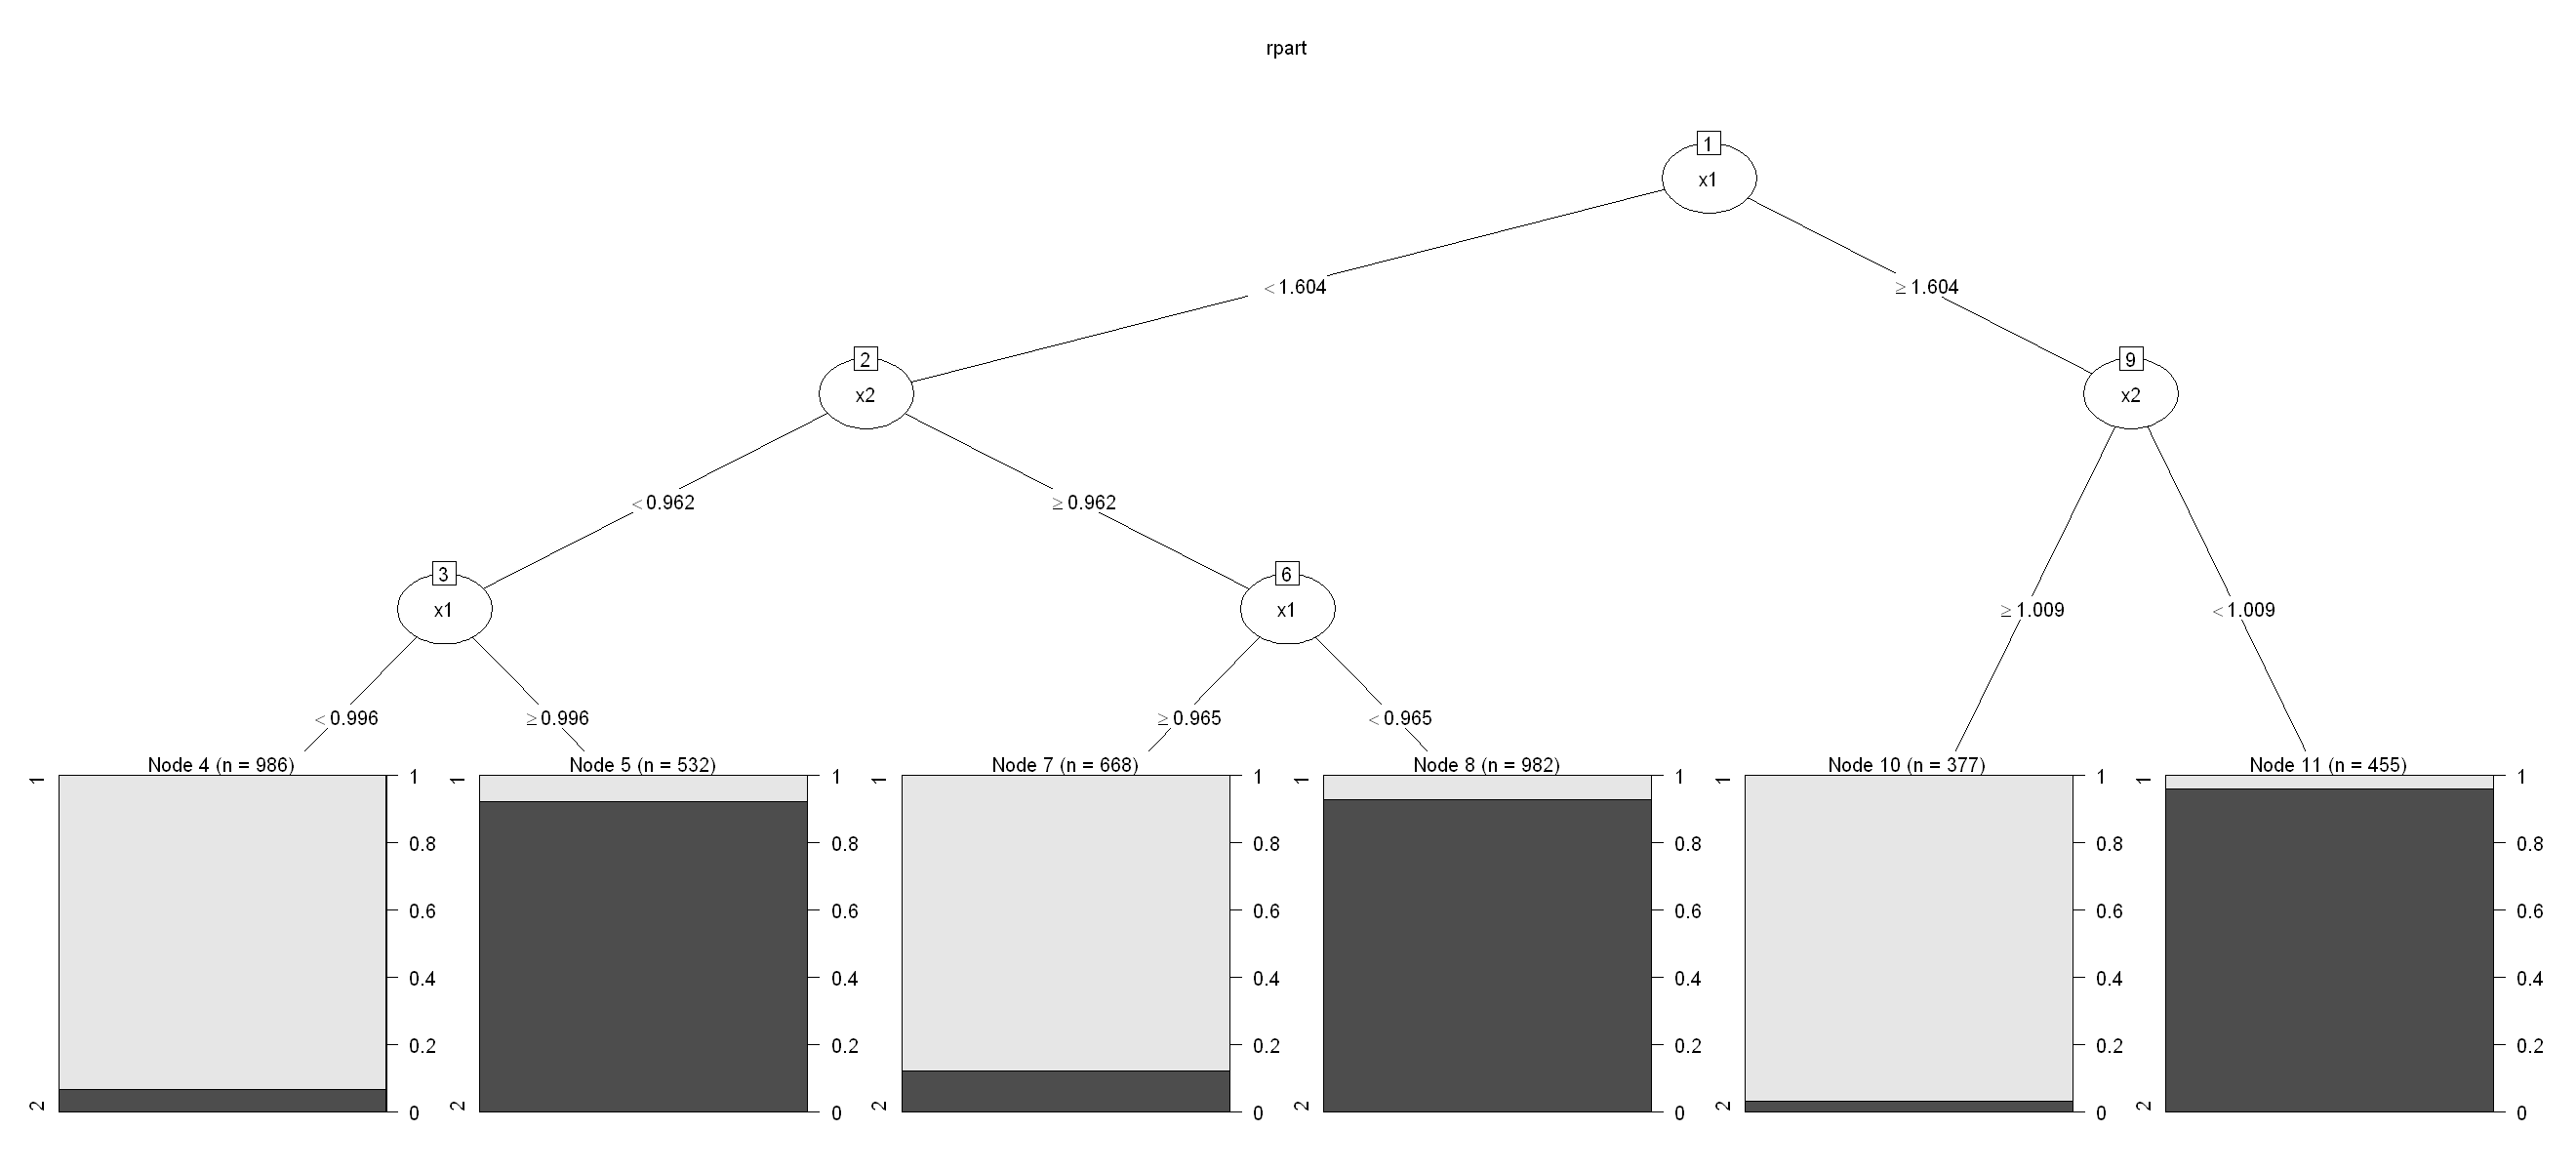

In [6]:
timestart <- Sys.time()
set.seed(100)
rt <- as.party(prune_se(rpart(y ~ ., data = d_tr), prune = TRUE, se = 1))
cat("耗时(s)：",difftime(Sys.time(), timestart, units = "secs"))

plot(rt,main = "rpart")

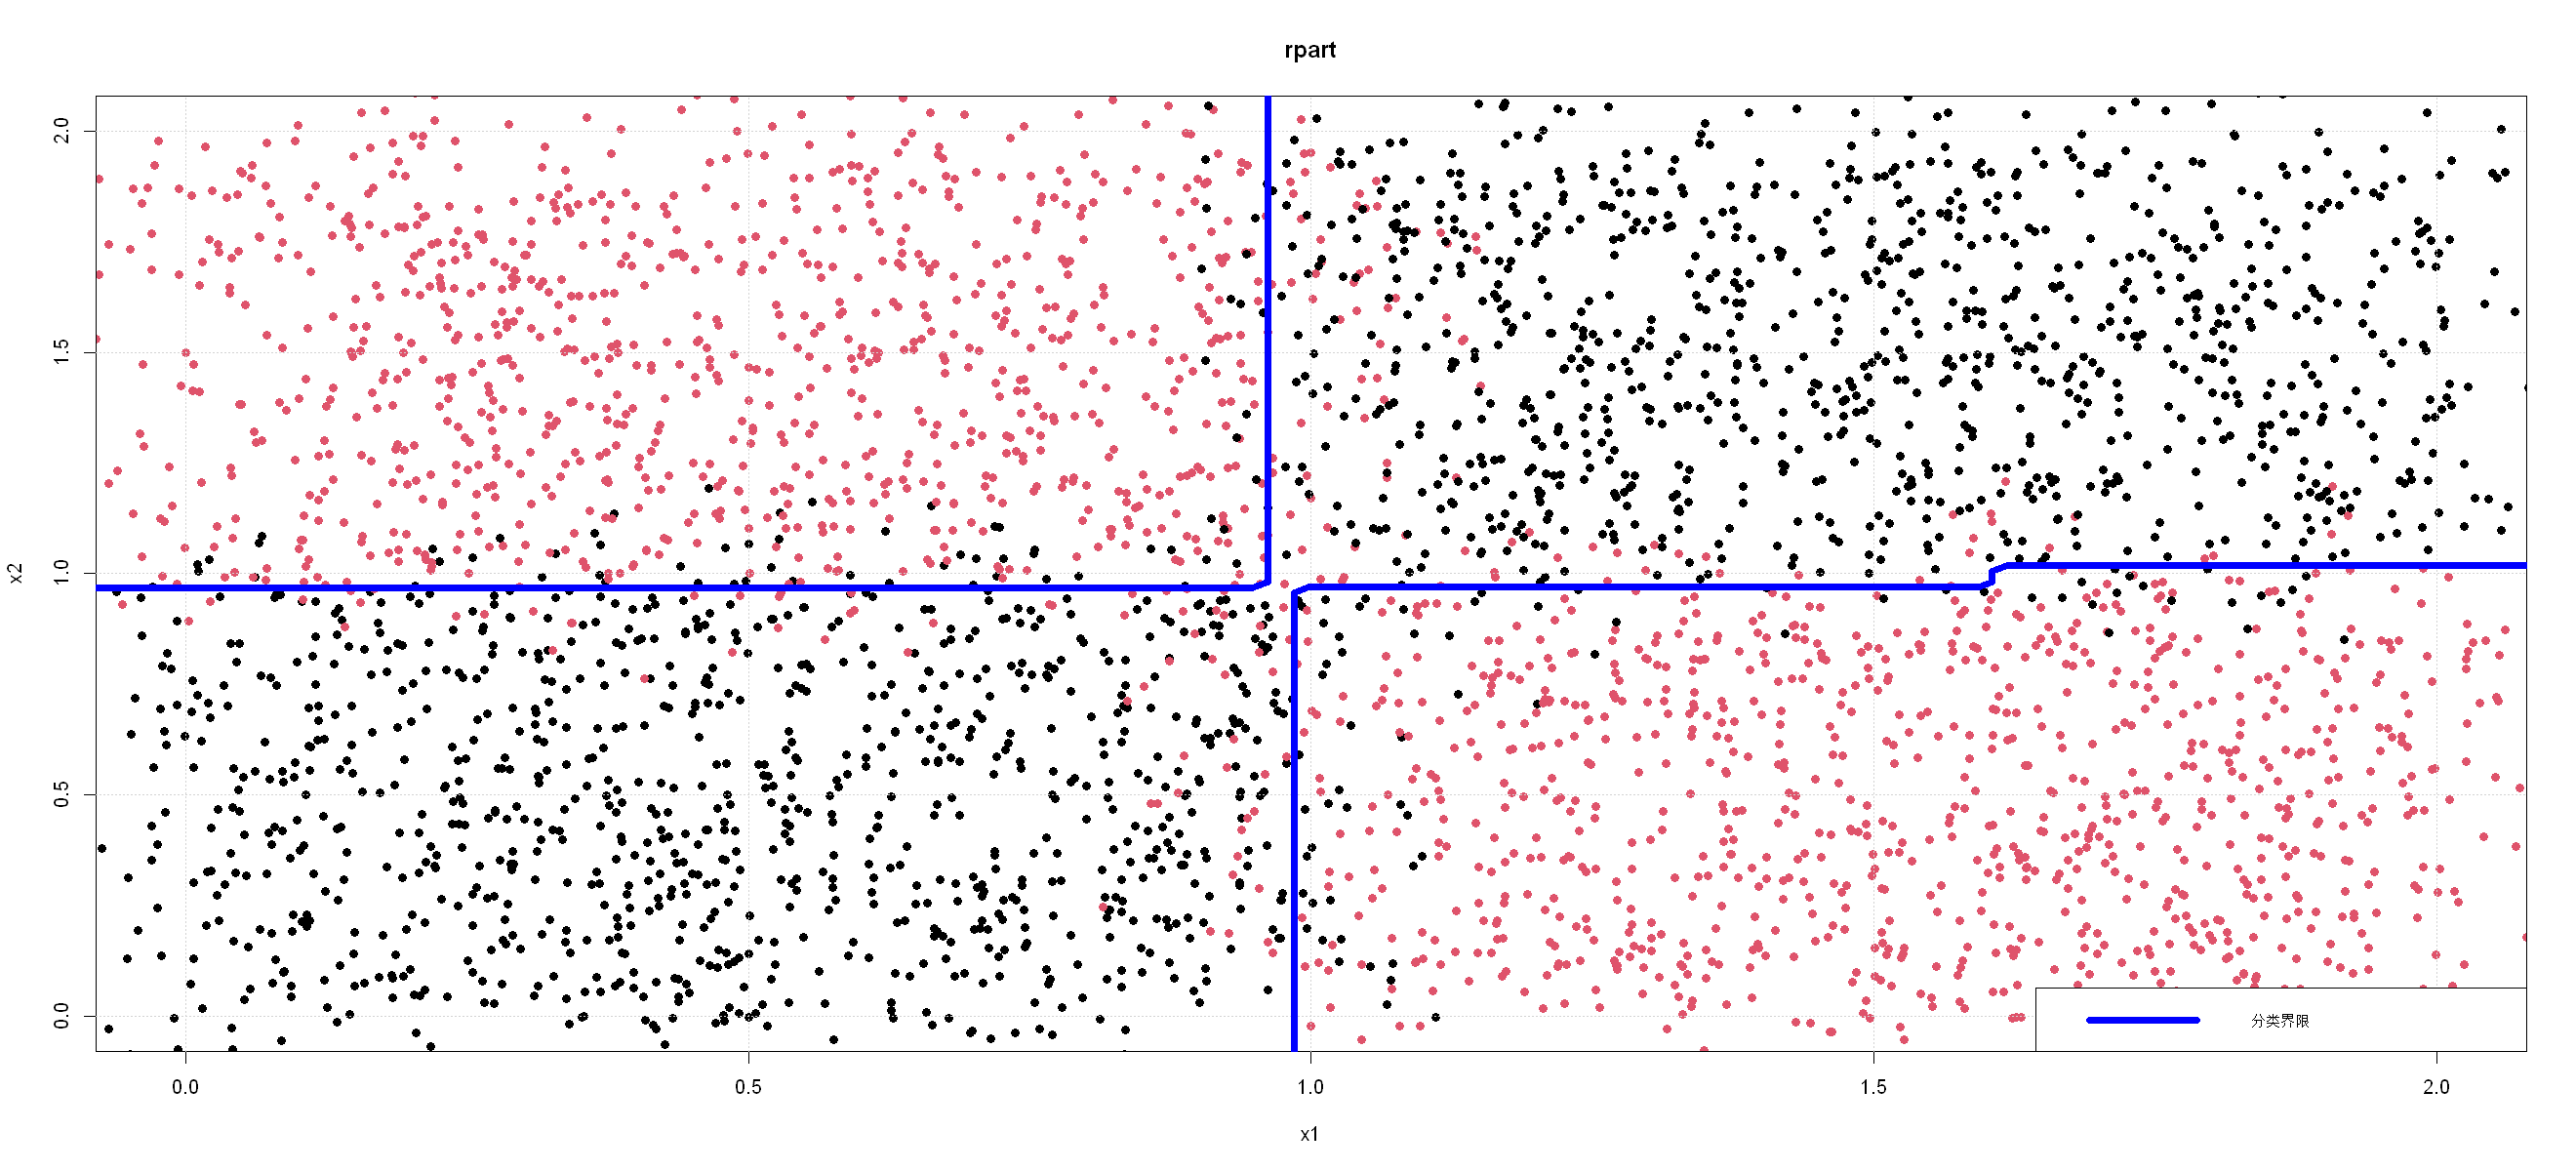

In [7]:
plot(x2 ~ x1, data = d_tr, xlim = c(0, 2), ylim = c(0, 2), col = c(1, 2)[y], pch = 16,main = "rpart")
grid()


x1 <- seq(min(d_tr$x1), max(d_tr$x1), length = 100)
x2 <- seq(min(d_tr$x2), max(d_tr$x2), length = 100)

pd <- function(x1, x2){
  predict(rt, data.frame(x1, x2), type = "prob")[, 1]
}

z <- outer(x1, x2, FUN = pd)
contour(x1, x2, z,
  levels = 0.5, drawlabels = FALSE,
  lwd = 6, col = "blue", add = TRUE
) # 画出分类界限--置信度为0.5的等高线

legend("bottomright","分类界限", lwd = 6, col = "blue", lty = 1,cex = 0.8)


---rpart算法较好地可以找到二者之间的界限

耗时(s)： 0.01184106

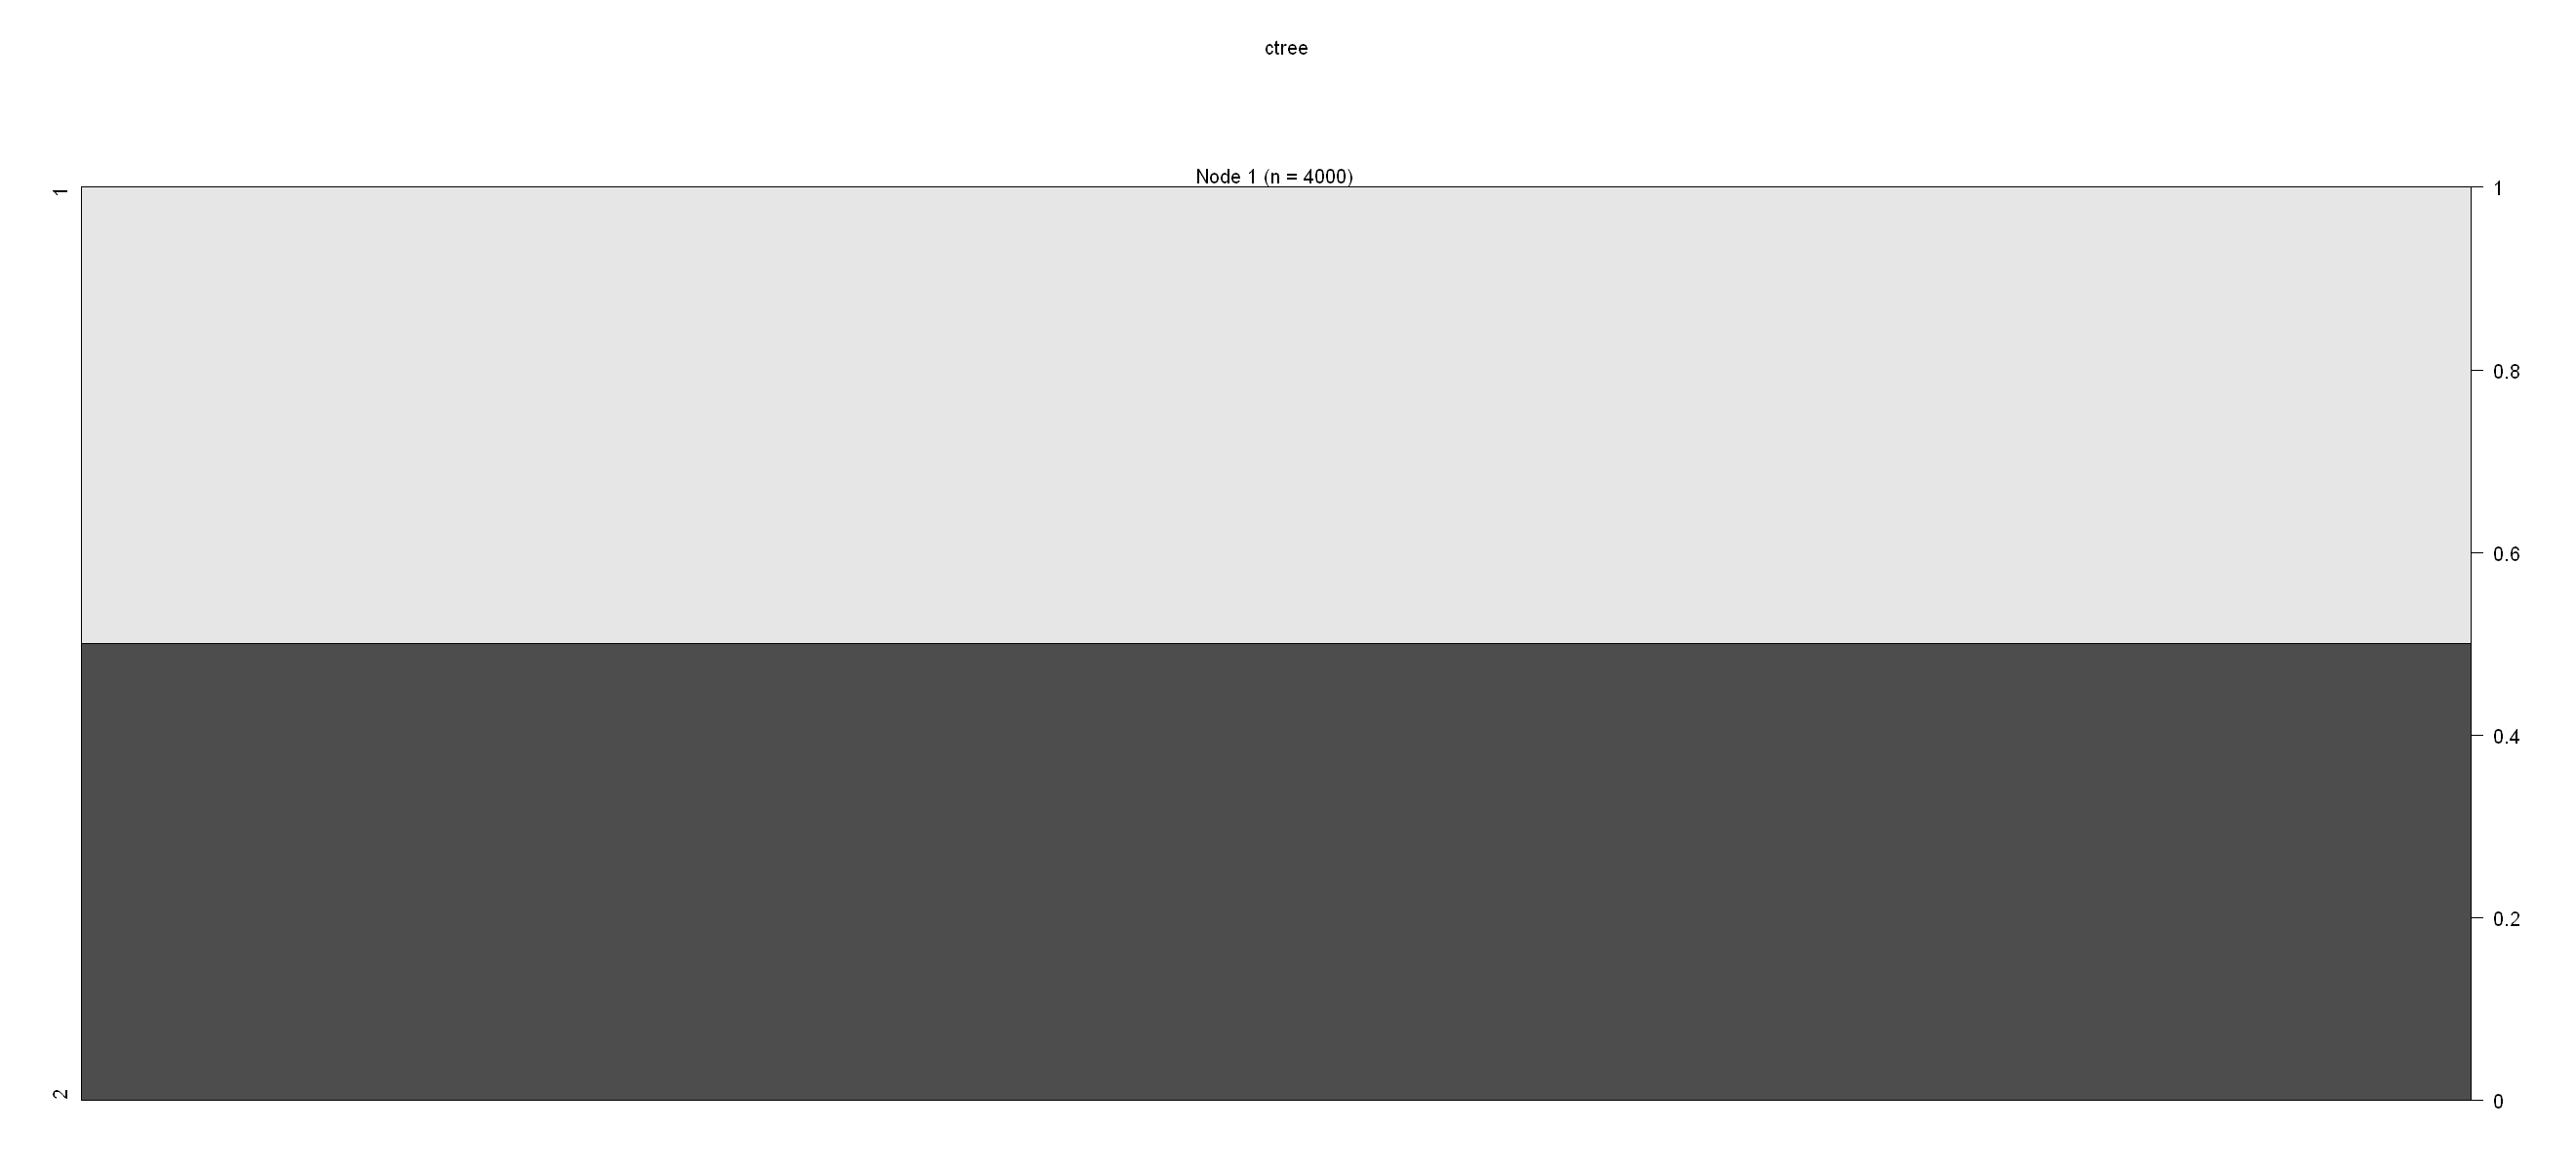

In [8]:
timestart <- Sys.time()
ct <- ctree(y ~ ., data = d_tr)
cat("耗时(s)：",difftime(Sys.time(), timestart, units = "secs"))

ct <- ctree(y ~ ., data = d_tr)
plot(ct,main = "ctree")

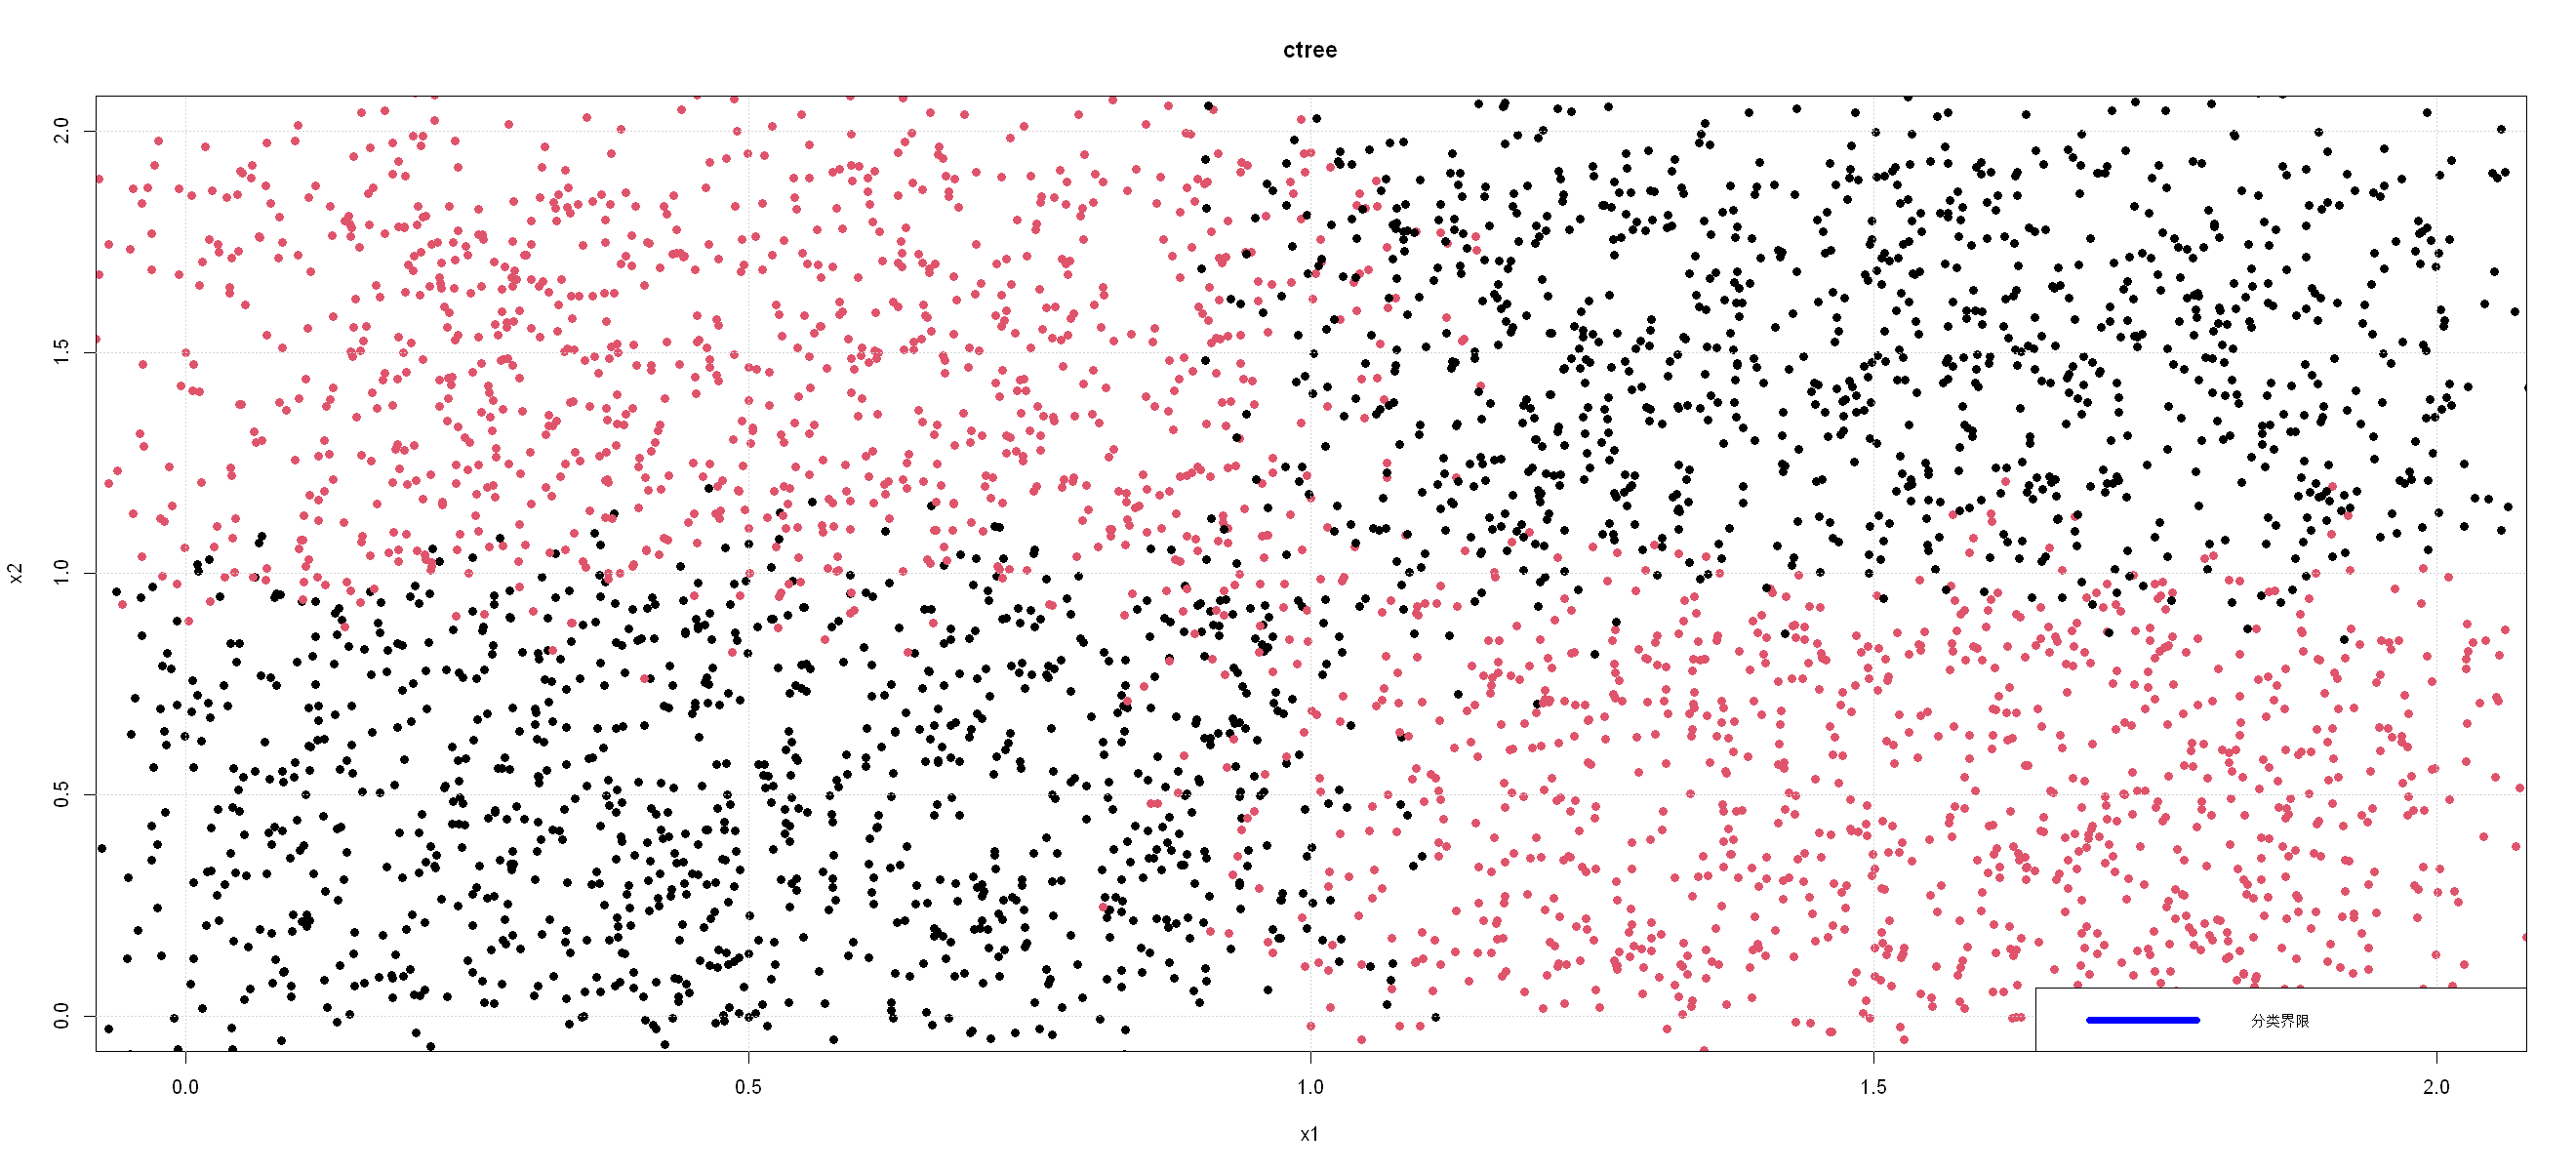

In [9]:
plot(x2 ~ x1, data = d_tr, xlim = c(0, 2), ylim = c(0, 2), col = c(1, 2)[y], pch = 16,main = "ctree")
grid()


x1 <- seq(min(d_tr$x1), max(d_tr$x1), length = 100)
x2 <- seq(min(d_tr$x2), max(d_tr$x2), length = 100)

pd <- function(x1, x2){
  predict(ct, data.frame(x1, x2), type = "prob")[, 1]
}

z <- outer(x1, x2, FUN = pd)
contour(x1, x2, z,
  levels = 0.5, drawlabels = FALSE,
  lwd = 6, col = "blue", add = TRUE
) # 画出分类界限--置信度为0.5的等高线

legend("bottomright","分类界限", lwd = 6, col = "blue", lty = 1,cex = 0.8)

---ctree算法不能找到二者之间的界限

耗时(s)： 18.05854

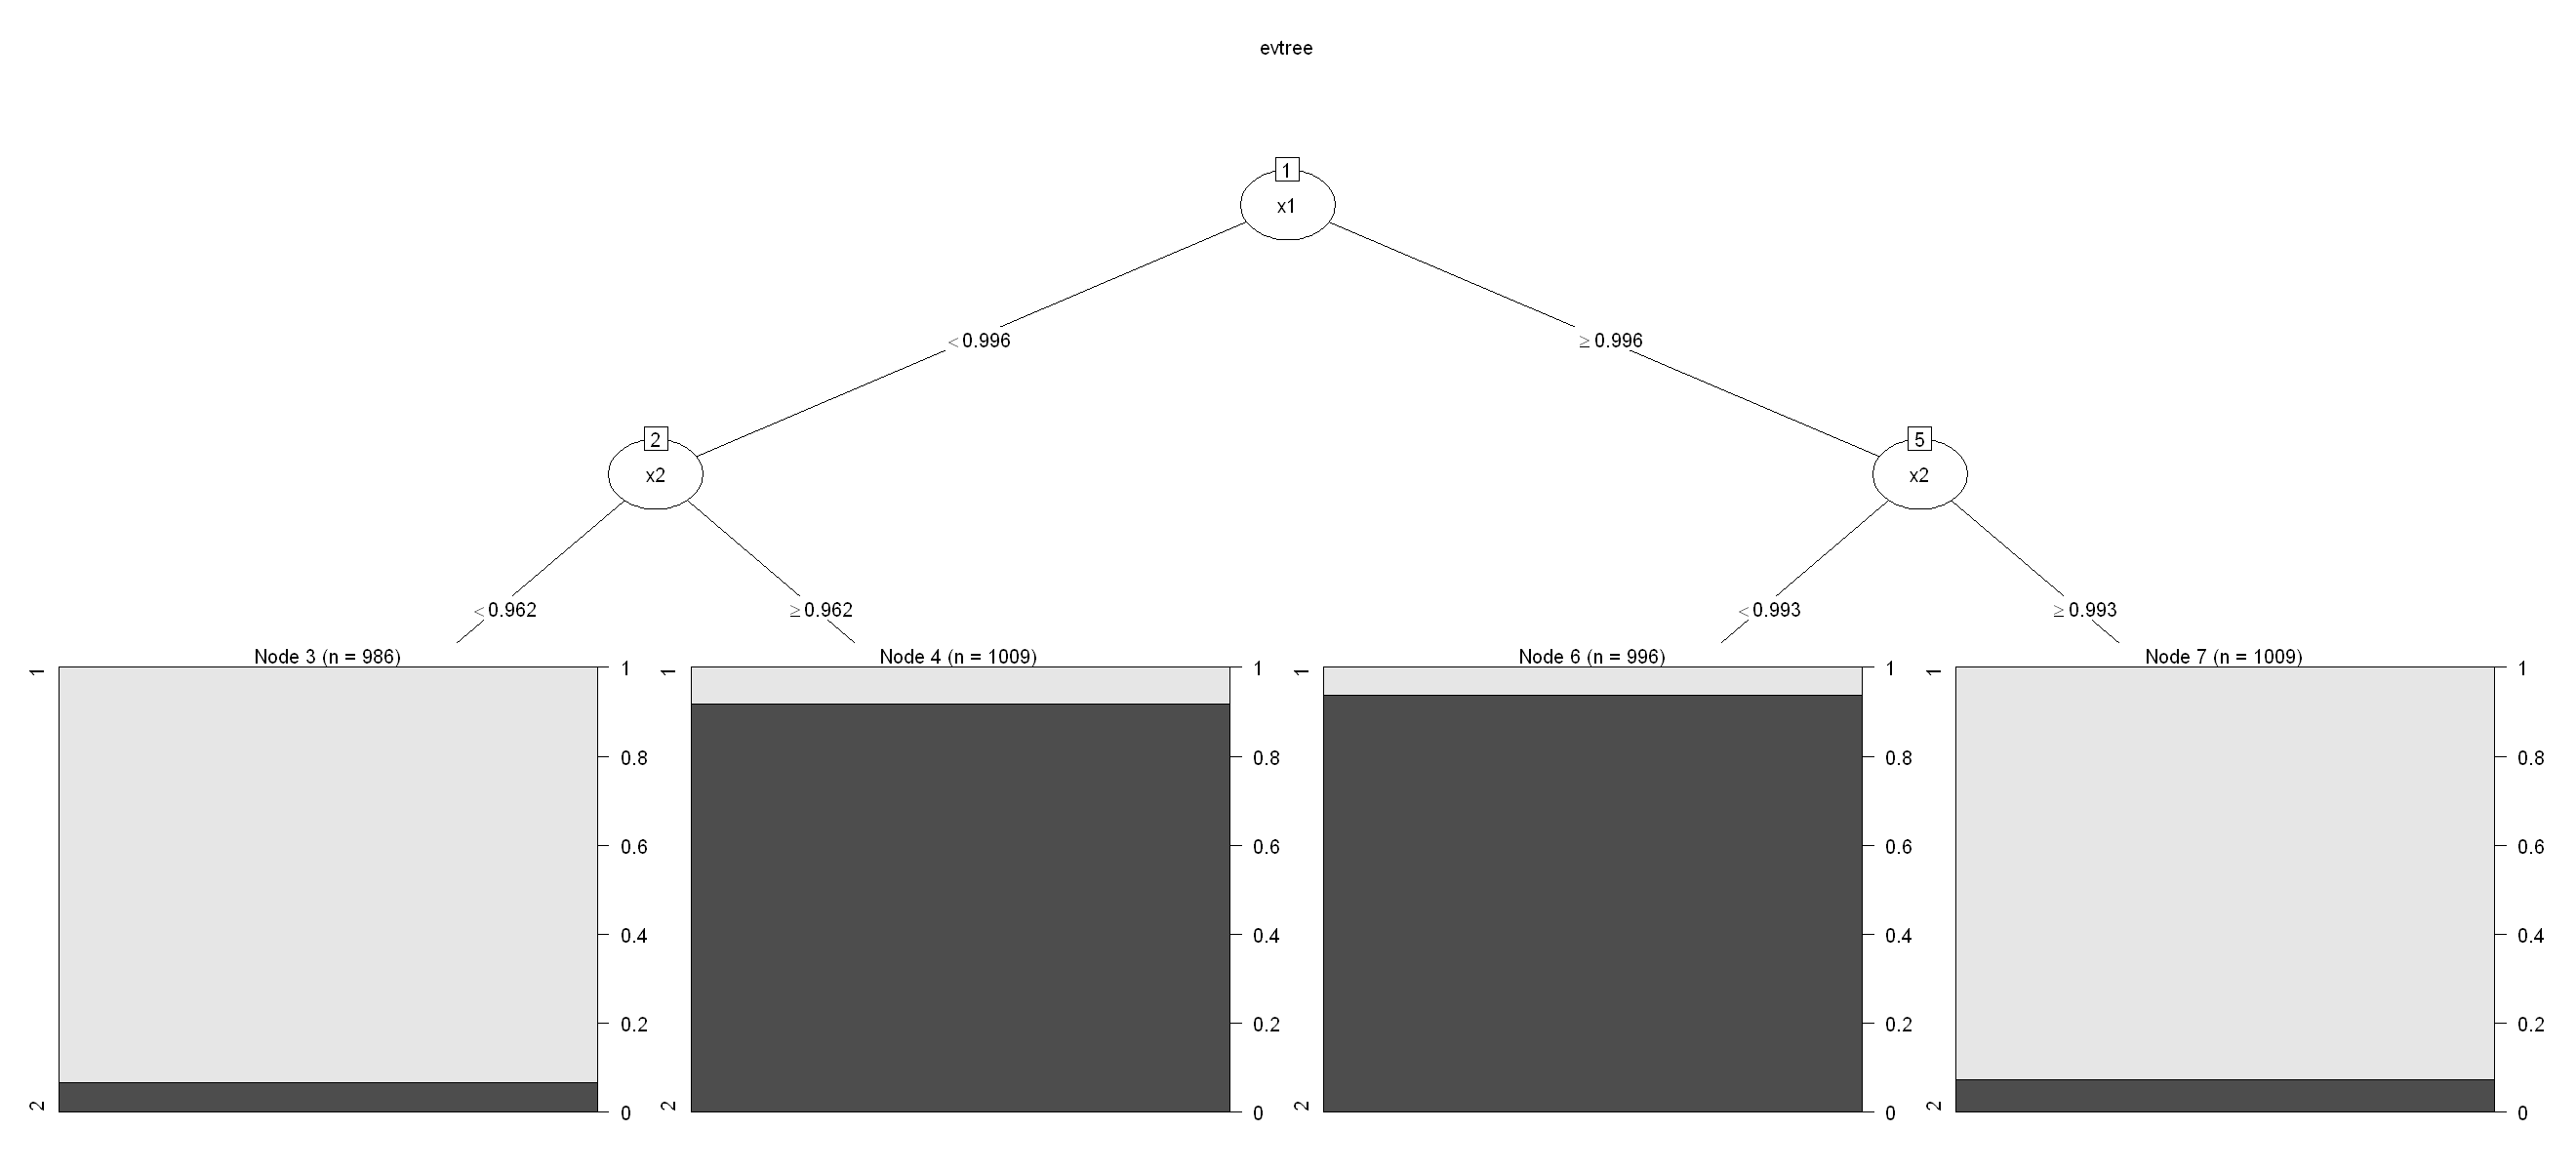

In [10]:
timestart <- Sys.time()
set.seed(100)
et1 <- evtree(y ~ ., data = d_tr)
cat("耗时(s)：",difftime(Sys.time(), timestart, units = "secs"))

plot(et1,main = "evtree")

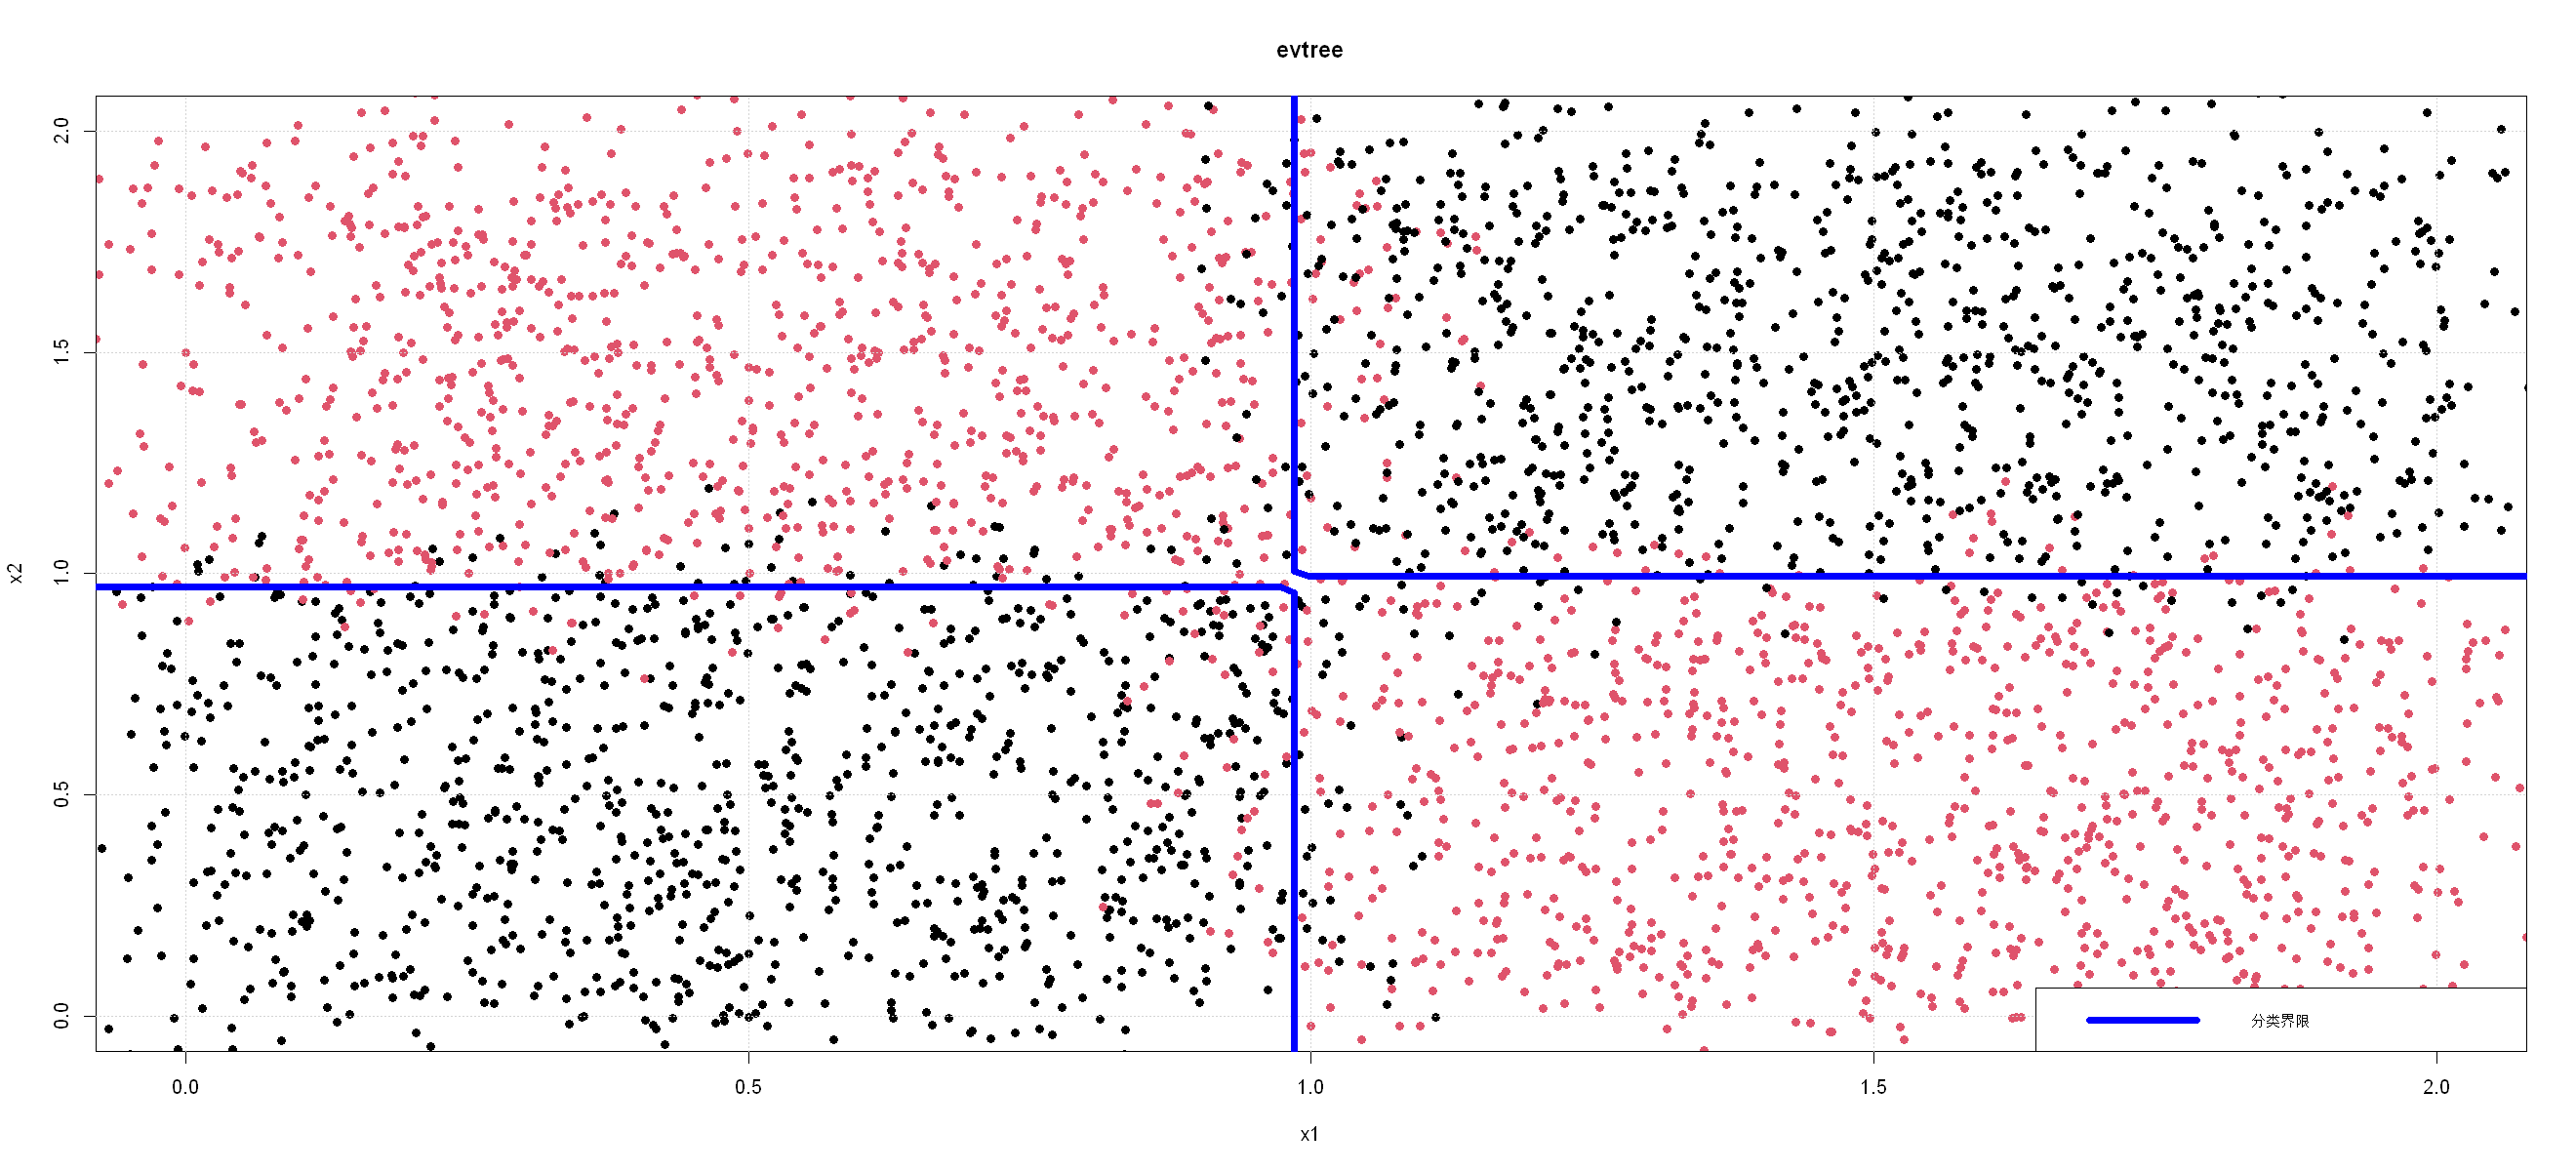

In [11]:
plot(x2 ~ x1, data = d_tr, xlim = c(0, 2), ylim = c(0, 2), col = c(1, 2)[y], pch = 16, main = "evtree")
grid()


x1 <- seq(min(d_tr$x1), max(d_tr$x1), length = 100)
x2 <- seq(min(d_tr$x2), max(d_tr$x2), length = 100)

pd <- function(x1, x2){
  predict(et1, data.frame(x1, x2), type = "prob")[, 1]
}

z <- outer(x1, x2, FUN = pd)
contour(x1, x2, z,
  levels = 0.5, drawlabels = FALSE,
  lwd = 6, col = "blue", add = TRUE
) # 画出分类界限--置信度为0.5的等高线

legend("bottomright","分类界限", lwd = 6, col = "blue", lty = 1,cex = 0.8)

改变随机种子，evtree可能会发生改变，实际上对样本空间的分割基本相同

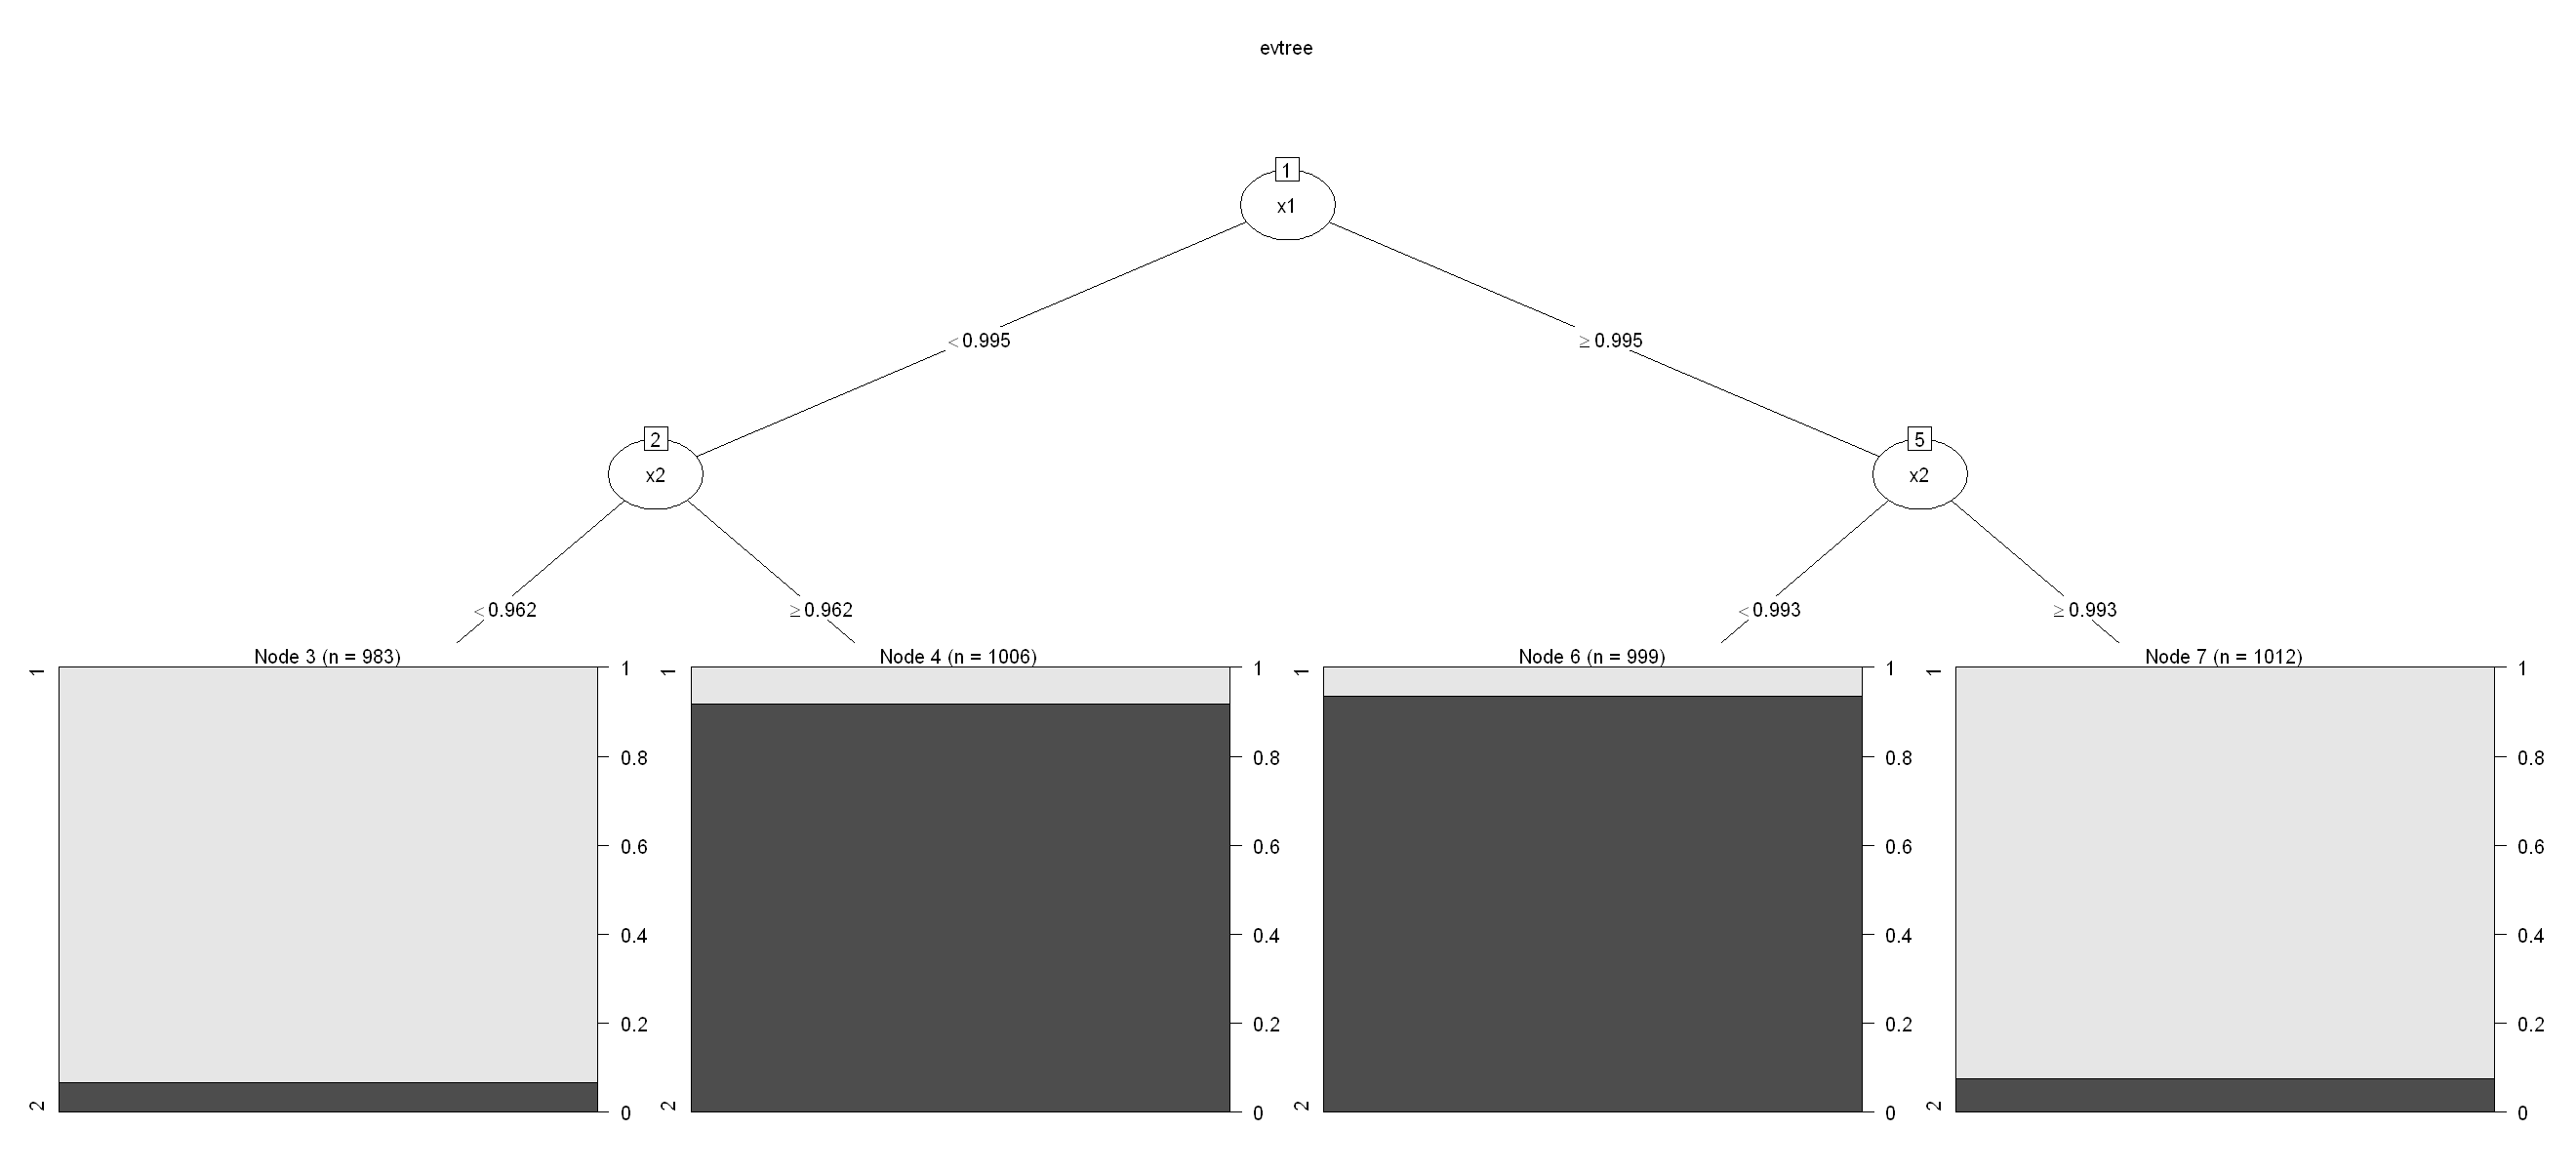

In [13]:
set.seed(500)
et2 <- evtree(y ~ ., data = d_tr)
plot(et2,main = "evtree")

测试集判错率

In [14]:
cat("\n          判错率")
cat("\n rpart  ：", mean(d_te$y != predict(rt, d_te)))
cat("\n ctree  ：", mean(d_te$y != predict(ct, d_te)))
cat("\n evtree1：", mean(d_te$y != predict(et1, d_te)))
cat("\n evtree2：", mean(d_te$y != predict(et2, d_te)))


          判错率
 rpart  ： 0.07925
 ctree  ： 0.5
 evtree1： 0.08
 evtree2： 0.08025